In [1330]:
import sys
!{sys.executable} -m pip install seaborn

     |████████████████████████████████| 215 kB 2.2 MB/s eta 0:00:01


In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

import numpy as np
from scipy import stats
import subprocess
import pandas as pd
import time
from tqdm import tqdm_notebook as tqdm


import requests
from lxml import etree
from lxml.etree import fromstring
from twobitreader import TwoBitFile


def get_sequence(chrom,start, stop):

    req = requests.get(("http://genome.ucsc.edu/cgi-bin/das/mm10/dna?segment=" + chrom + ":" + str(int(start)) + "," + str(int(stop))), stream=True)
    req.raw.decode_content = True  # ensure transfer encoding is honoured
    b = etree.parse(req.raw)
    return "".join([i[1:] for i in str(etree.tostring(b)).split("length")[1].split("\\n</DNA>\\")[0].split(">")[1].split("\\")[1:]])
def complement(dna):
    complement = {'a': 'u', 'c': 'g', 'g': 'c', 'u': 'a' ,'n':'n'}
    return ''.join([complement[base] for base in dna[::-1]])

def sequence(reads):
    sequences = make_array()
    genome = TwoBitFile("hg38.2bit")
    
    for i in tqdm(np.arange(reads.num_rows)): 
        chrom = reads.column("chrom").item(i)
        start = int(reads.column("start").item(i))
        stop = int(reads.column("stop").item(i))
        strand = reads.column("strand").item(i)
        chromid = genome[chrom]
        sequence = chromid[start-1:stop].lower().replace("t", "u")
        if strand == "-":
            sequence = complement(sequence)
        sequences = np.append(sequences, sequence)
    reads = reads.with_column("RNA sequences", sequences)
    #.group("Seed Sequence?")
    return reads



In [971]:
stim = Table().read_table("JSL_stim/stim.csv")
stim = stim.with_column("center", [int(i/2) for i in stim.column("start")+ stim.column("stop")])
stim = stim.with_column("start", stim.column("center")-4).with_column("stop", stim.column("center")+4).drop("center")
#stim.to_csv("JSL_stim/stim_8.csv")

In [ ]:
from sympy import Interval, Union
def union(data):
    """ Union of a list of intervals e.g. [(1,2),(3,4)] """
    intervals = [Interval(begin, end) for (begin, end) in data]
    u = Union(*intervals)
    return [list(u.args[:2])] if isinstance(u, Interval) \
       else list(u.args)
x = union([(10, 12), (14, 16), (15, 22)])
import numpy as np
x[0].start

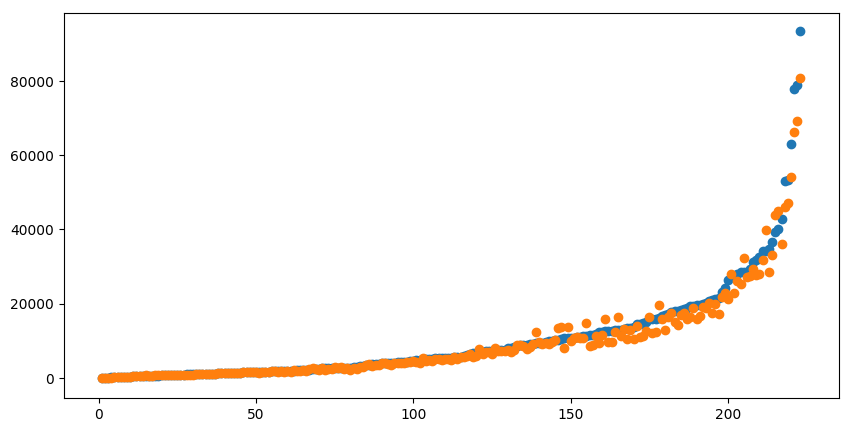

<Figure size 640x480 with 0 Axes>

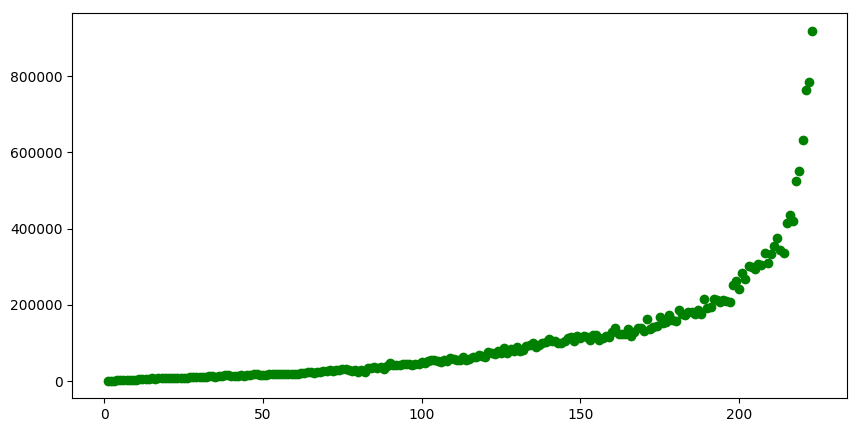

In [81]:
count_data = Table().read_table("JSL_stim/RBPs/jsl_stim.csv").join("geneid", Table().read_table("JSL_stim/RBPs/jsl_unstim.csv")).relabeled("count", "jurkat hits").relabeled("count_2", "k562 hits")
utr_counts = Table().read_table("JSL_stim/RBPs/utr_hits.csv")
count_data = count_data.join("geneid", utr_counts).sort("jurkat hits", descending=True)

plt.style.use("default") 
plt.figure(figsize=(10,5))
x = np.arange(len(count_data.column(0)), 0, -1)
plt.scatter(x, count_data.column(1))
plt.scatter(x, count_data.column(2))
plt.savefig("foo.pdf")
plt.figure()

plt.style.use("default") 
plt.figure(figsize=(10,5))
plt.scatter(x, count_data.column(3), c="green")
plt.savefig("foo-1.pdf")

In [ ]:
RBPs = make_array()

for rbp in Table().read_table("JSL_stim/unstim_overlap_eCLIP.csv").column("RBP"):
    RBPs = np.append(RBPs, np.asarray(rbp.split(',')))

In [ ]:
count_data = Table().with_column("geneid", RBPs).group(0)
count_data

In [425]:
import os
rbps = [i.split(".")[0] for i in os.listdir("JSL_stim/eCLIP copy")]
rbps.remove('')

count_data = Table().with_column("geneid", rbps).sort("geneid", descending=False)

In [429]:
count_data

geneid
AARS
AGGF1
AKAP8L
BUD13
CPSF6
CSTF2T
DDX24
DDX3X
DDX42
DDX55


In [1025]:
stim_tbl = Table().read_table("JSL_stim/stim_overlap_eCLIP_90.csv")
stim_tbl = stim_tbl.with_column("RBP count", [i.count(",") + 1 for i in stim_tbl.column("RBP")])
stim_tbl= stim_tbl.with_column("AUC Differential Binding", stim_tbl.column("AUC Differential Binding")/ stim_tbl.column("RBP count"))

In [1026]:
unstim_tbl = Table().read_table("JSL_stim/unstim_overlap_eCLIP_90.csv")
unstim_tbl = unstim_tbl.with_column("RBP count", [i.count(",") + 1 for i in unstim_tbl.column("RBP")])
unstim_tbl= unstim_tbl.with_column("AUC Differential Binding", unstim_tbl.column("AUC Differential Binding")/ unstim_tbl.column("RBP count"))

In [430]:
stim_tbl = Table().read_table("JSL_stim/stim_overlap_eCLIP_90_90.csv")

#upper_cutoff = percentile(10, Table().read_table("JSL_stim/stim_overlap_eCLIP_90_90.csv").column("AUC Differential Binding"))
#stim_tbl = stim_tbl.where("AUC Differential Binding", are.above_or_equal_to(upper_cutoff))
#stim_tbl = stim_tbl.with_column("RBP count", [i.count(",") + 1 for i in stim_tbl.column("RBP")])
#stim_tbl= stim_tbl.with_column("AUC Differential Binding", stim_tbl.column("AUC Differential Binding")/ stim_tbl.column("RBP count"))

In [431]:
unstim_tbl = Table().read_table("JSL_stim/unstim_overlap_eCLIP_90_90.csv")
#upper_cutoff = percentile(10, Table().read_table("JSL_stim/unstim_overlap_eCLIP_90_90.csv").column("AUC Differential Binding"))
#unstim_tbl = unstim_tbl.where("AUC Differential Binding", are.above_or_equal_to(upper_cutoff))
#unstim_tbl = unstim_tbl.with_column("RBP count", [i.count(",") + 1 for i in unstim_tbl.column("RBP")])
#unstim_tbl= unstim_tbl.with_column("AUC Differential Binding", unstim_tbl.column("AUC Differential Binding")/ unstim_tbl.column("RBP count"))

In [432]:
auc = make_array()
overlap = stim_tbl
RBP = count_data
for name in tqdm(RBP.column("geneid")):
    sum_rbp = np.sum(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    len_rpb = len(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    auc = np.append(auc,sum_rbp/len_rpb )
count_data = count_data.with_column("jurkat AUC", auc)#.where(0, are.not_equal_to('nan'))



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [433]:
auc = make_array()
overlap = unstim_tbl
for name in tqdm(RBP.column("geneid")):
    sum_rbp = np.sum(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    len_rpb = len(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    auc = np.append(auc,sum_rbp/len_rpb)
count_data = count_data.with_column("k562 AUC", auc)#.where(0, are.not_equal_to('nan'))
count_data 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


geneid,jurkat AUC,k562 AUC
AARS,39.6536,39.2683
AGGF1,38.7205,31.5024
AKAP8L,38.2948,41.5318
BUD13,36.2479,37.6778
CPSF6,40.7729,43.2795
CSTF2T,46.3785,42.4349
DDX24,33.69,35.5642
DDX3X,36.7526,30.6437
DDX42,44.648,47.2307
DDX55,38.994,41.3729


In [435]:
count_data = count_data.join("geneid", Table().read_table("JSL_stim/utr_hits.csv"))#.to_csv("JSL_stim/count_data.csv")

In [289]:
count_data = Table().read_table("JSL_stim/count_data.csv")
#count_data = count_data.sort("utr_hits", descending=True).take(np.arange(200))

In [1006]:
count_data = count_data.where("jurkat AUC", are.above(0)).where("k562 AUC", are.above(0))

In [282]:
count_data = count_data.with_column("jurkat AUC", count_data.column("jurkat AUC")/ count_data.column("utr_hits"))

In [283]:
count_data = count_data.with_column("k562 AUC", count_data.column("k562 AUC")/ count_data.column("utr_hits"))

In [810]:
count_data = count_data.sort("jurkat AUC", descending=False)

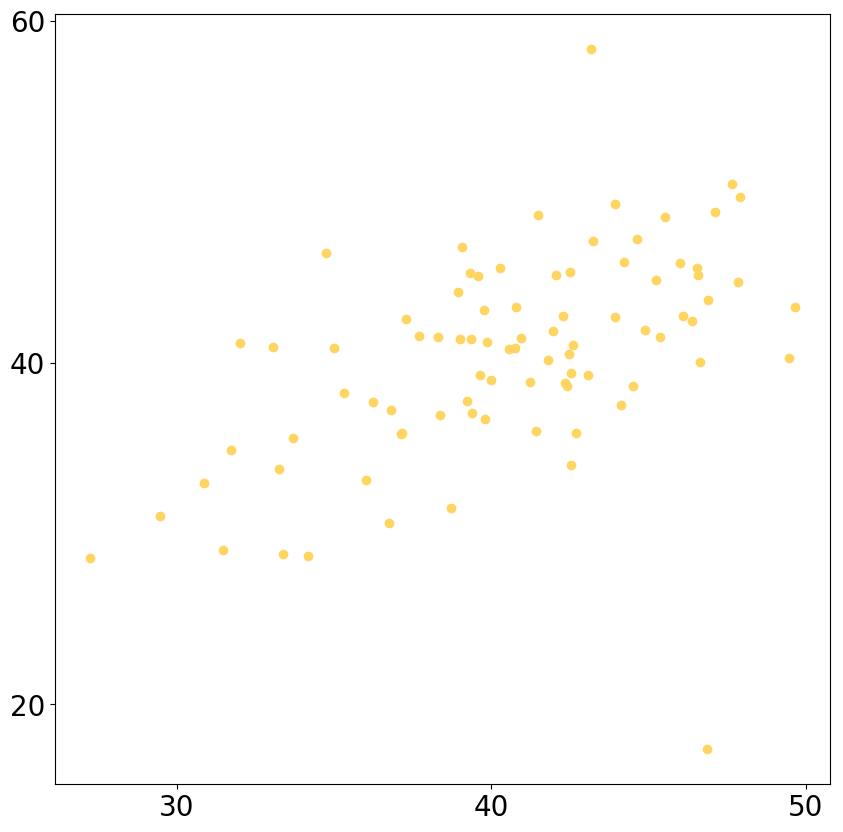

In [436]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 
import numpy as np
plt.figure(figsize=(10,10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.grid(False)


rng = np.random.RandomState(0)

plt.scatter(count_data.column(1), count_data.column(2), c='#ffd561',
            cmap='viridis')

plt.savefig("foo.pdf")

In [437]:
super_names = Table().read_table("JSL_stim/Uniprot/all.csv")

ids = []
supa = []

uniprot_all = []
for geneid in tqdm(count_data.column(0)):
    super_short = super_names.with_column("Truth", [geneid in i for i in super_names.column("Gene names")]).where("Truth", True)
    if super_short.num_rows > 0:
        ids.append(geneid)
        supa.append(super_short.column("Gene names").item(0).split(" ")[0])
        uniprot_all.append(True)
    else:
        ids.append(geneid)
        supa.append(geneid)
        uniprot_all.append(False)
count_data = count_data.join("geneid", Table().with_columns("geneid", ids, "super_name",supa,  "uniprot_all",uniprot_all))#.relabeled("geneid", "old id").relabeled("super_name", "geneid")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [440]:
count_data.with_column("match", [i==j for i,j in zip(count_data.column("geneid"), count_data.column("super_name"))])

geneid,jurkat AUC,k562 AUC,utr_hits,super_name,uniprot_all,match
AARS,39.6536,39.2683,7144,AARSD1,True,False
AGGF1,38.7205,31.5024,17618,AGGF1,True,True
AKAP8L,38.2948,41.5318,16008,AKAP8L,True,True
BUD13,36.2479,37.6778,11097,BUD13,True,True
CPSF6,40.7729,43.2795,14429,CPSF6,True,True
CSTF2T,46.3785,42.4349,22674,CSTF2T,True,True
DDX24,33.69,35.5642,6046,DDX24,True,True
DDX3X,36.7526,30.6437,7497,DDX3X,True,True
DDX42,44.648,47.2307,7618,DDX42,True,True
DDX55,38.994,41.3729,25481,DDX55,True,True


In [441]:
super_names = Table().read_table("JSL_stim/Uniprot/cytoplasmic_proteins.csv")

cyto = []
for geneid in tqdm(count_data.column(0)):
    super_short = super_names.with_column("Truth", [geneid in i for i in super_names.column("Gene names")]).where("Truth", True)
    if super_short.num_rows > 0:
        cyto.append(True)
    else:
        cyto.append(False)
count_data = count_data.with_column("cytoplasmic", cyto)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [449]:
a = set(list(count_data.column("geneid")))
b = set(list(combo.column("geneid")))

a.difference(b)

{'LIN28B', 'TAF15'}

In [307]:
count_data.where("uniprot_all", True).num_rows

126

In [134]:
count_data.where("uniprot_all", True).num_rows

128

In [216]:
count_data.where("uniprot_all", True).num_rows

126

In [217]:
count_data.where("cytoplasmic", True).num_rows

77

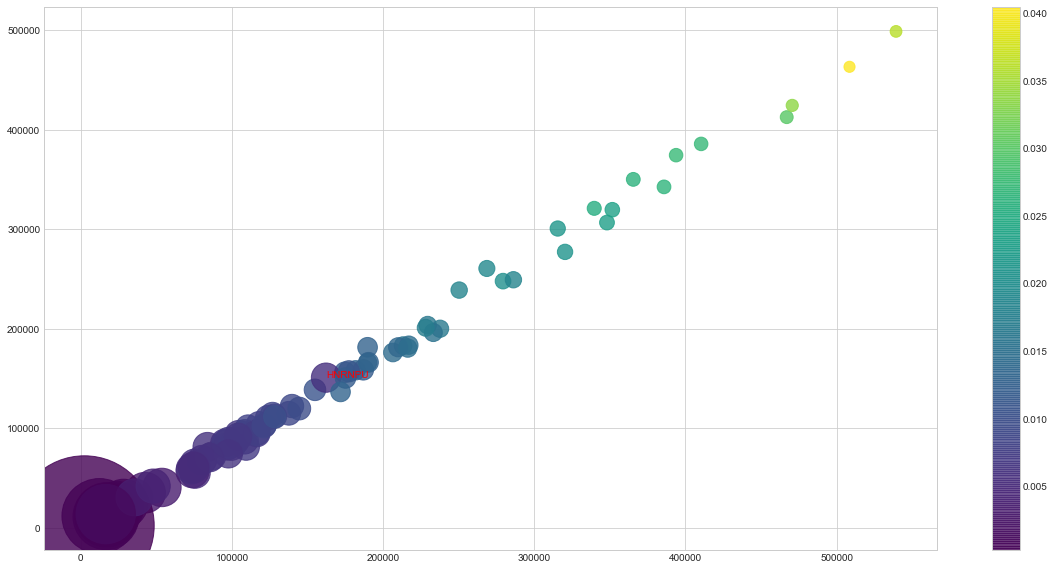

In [519]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
plt.figure(figsize=(20,10))


rng = np.random.RandomState(0)
x = count_data.column(1)
y = count_data.column(2)
hits = count_data.column(3)
colors = hits/sum(hits)
sizes = sum(hits)/hits * 5

plt.scatter(x, y, c=colors, s=sizes, alpha=0.8,
            cmap='viridis')
c_data = count_data#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(60))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))
data_tupules = [(i, j) for i,j in zip(c_data.column(1), c_data.column(2))]

for i in np.arange(len(data_tupules)):
    if c_data.column(0).item(i) == "HNRNPU":
        plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')

plt.colorbar();  # show color scale
plt.savefig("foo.pdf")

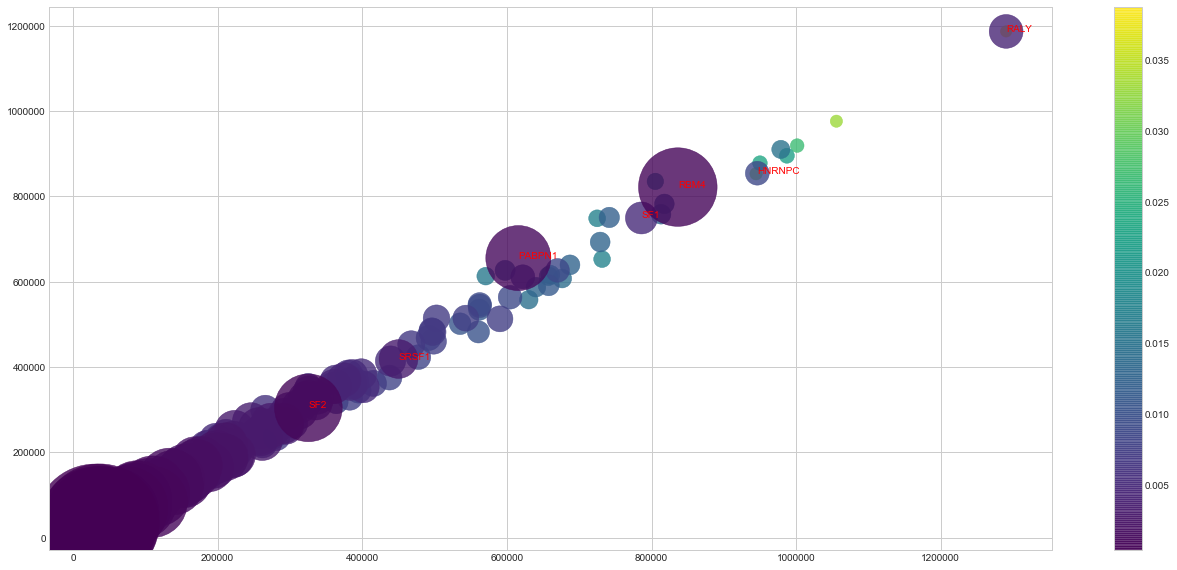

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
plt.figure(figsize=(20,10))


rng = np.random.RandomState(0)
x = count_data.column(4)
y = count_data.column(5)
hits = count_data.column(3)
colors = hits/sum(hits)
sizes = sum(hits)/hits * 5

plt.scatter(x, y, c=colors, s=sizes, alpha=0.8,
            cmap='viridis')
c_data = count_data#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(60))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))
data_tupules = [(i, j) for i,j in zip(c_data.column(4), c_data.column(5))]

for i in np.arange(len(data_tupules)):
    if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC"):
        plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')

plt.colorbar();  # show color scale
plt.savefig("foo.pdf")

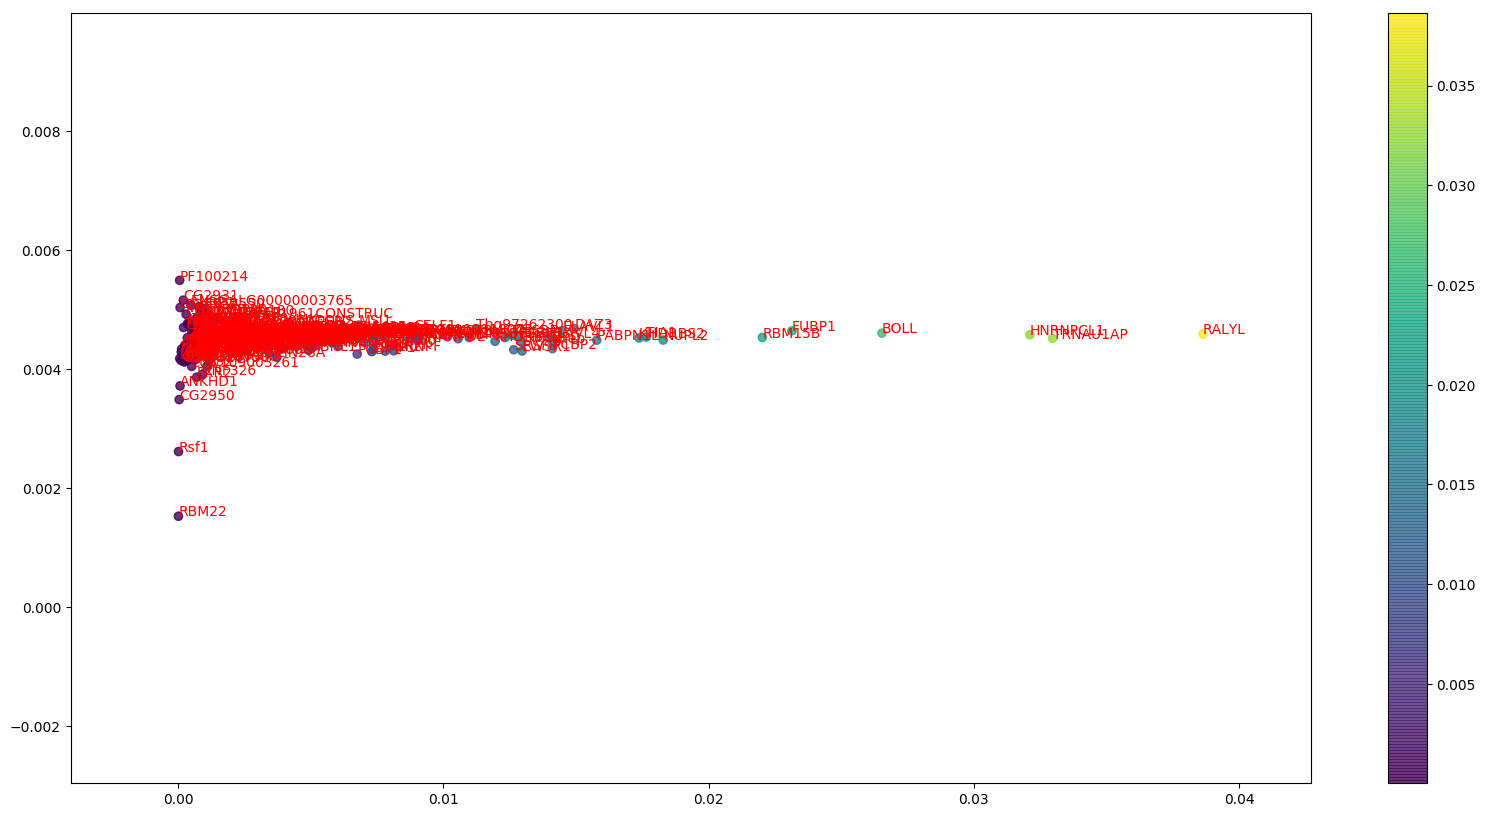

In [218]:
lin_tbl = count_data.select("utr_hits").with_column("utr_hits",count_data.column("utr_hits")/sum(count_data.column("utr_hits")))
lin_tbl = lin_tbl.with_column('enrich hits', (count_data.column("jurkat AUC")+count_data.column("k562 AUC"))/sum(count_data.column("jurkat AUC")+count_data.column("k562 AUC")))
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 

import numpy as np
plt.figure(figsize=(20,10))


rng = np.random.RandomState(0)
x = lin_tbl.column(0)
y = lin_tbl.column(1)
hits = count_data.column(3)
colors = hits/sum(hits)
sizes = sum(hits)/hits * 5

plt.scatter(x, y, c=colors, alpha=0.8,
            cmap='viridis')
c_data = count_data#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    #if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
    plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')

plt.colorbar();  # show color scale 
plt.savefig("foo.pdf")

In [484]:
exp = Table().read_table("JSL_stim/JSL_stim_diff.csv")
exp = exp.with_column("geneid", [i.upper() for i in exp.column("geneid")])
exp = exp.with_column("resting", (exp.column("resting1") + exp.column("resting2"))/2)
exp = exp.with_column("stim", (exp.column("stim1") + exp.column("stim2"))/2)
exp = exp.where("resting", are.above(0)).where("stim", are.above(0))

In [485]:
exp = exp.with_column("FC(stimVSresting)", (exp.column("stim")/exp.column("resting")))
exp = exp.with_column("Log2FC(stimVSresting)", np.log2(exp.column("FC(stimVSresting)")))

In [486]:
combo = count_data.join("geneid", exp)
combo.num_rows

84

In [458]:
print(combo.where("cytoplasmic", True).num_rows, combo.where("cytoplasmic", False).num_rows)

52 32


In [198]:
print(combo.where("cytoplasmic", True).num_rows, combo.where("cytoplasmic", False).num_rows)

61 42


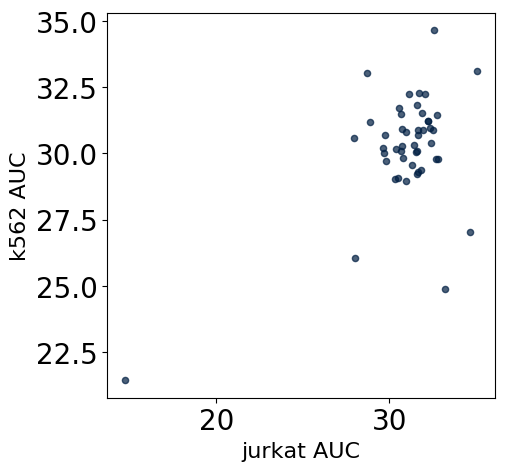

In [364]:
combo.scatter("jurkat AUC", "k562 AUC")

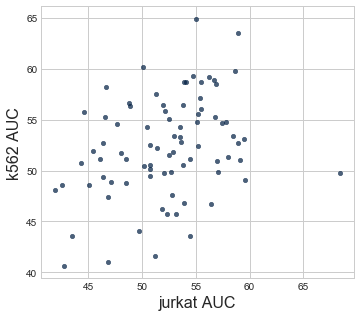

In [340]:
combo.scatter("jurkat AUC", "k562 AUC")

In [1004]:
combo = combo.where("k562 AUC", are.above(0)).where("geneid", are.not_equal_to("SBDS")).where("jurkat AUC", are.above(0)).where("geneid", are.not_equal_to("SBDS"))

In [987]:
tuth = "SERBP1 KHSRP UPF1 IGF2BP1 SND1 FAM120A DDX3X IGF2BP2 XRCC6 RPS5 KHDRBS1 EIF4G2"
tuth = tuth + "PUM2 FMR1 LARP4 FXR1 TIA1 LIN28B NCBP2 DDX42 DHX30 RBFOX2 PPIL4 FXR1 FXR2 DDX6 LARP7 NPM1 EFTUD2"
tuth = tuth + "SERBP1 KHSRP UPF1 SND1 IGF2BP1 IGF2BP2 DDX3X XRCC6 FAM120A  RPS5 KHDRBS1 PUM2 FMR1 LARP4"
tuth = tuth + "FXR1 TIA1 DDX42 DHX30  NCBP2 LARP4 FXR1 DDX6 FXR2 PPIL4 RBFOX2 DHX30 EIF4G2 EIF4G2 EFTUD2 LARP7 NPM1 DDX42 LIN28B"


combo = combo.with_column("truth", [name in tuth for name in combo.column("geneid")]).where("truth", True)

In [495]:
combo = combo.where("geneid", are.not_equal_to("SBDS"))

In [563]:
import os
rbps = [i.split(".")[0] for i in os.listdir("JSL_stim/eCLIP copy")]
rbps.remove('')

count_data = Table().with_column("geneid", rbps).sort("geneid", descending=False)

stim_tbl = Table().read_table("JSL_stim/stim_overlap_eCLIP_90_90.csv")
unstim_tbl = Table().read_table("JSL_stim/unstim_overlap_eCLIP_90_90.csv")

auc = make_array()
overlap = stim_tbl
RBP = count_data
for name in tqdm(RBP.column("geneid")):
    sum_rbp = np.sum(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    len_rpb = len(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    auc = np.append(auc,sum_rbp/len_rpb )
count_data = count_data.with_column("jurkat AUC", auc)#.where(0, are.not_equal_to('nan'))

auc = make_array()
overlap = unstim_tbl
for name in tqdm(RBP.column("geneid")):
    sum_rbp = np.sum(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    len_rpb = len(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    auc = np.append(auc,sum_rbp/len_rpb)
count_data = count_data.with_column("k562 AUC", auc)#.where(0, are.not_equal_to('nan'))
count_data 
count_data = count_data.join("geneid", Table().read_table("JSL_stim/utr_hits.csv"))



super_names = Table().read_table("JSL_stim/Uniprot/cytoplasmic_proteins.csv")

cyto = []
for geneid in tqdm(count_data.column(0)):
    super_short = super_names.with_column("Truth", [geneid in i for i in super_names.column("Gene names")]).where("Truth", True)
    if super_short.num_rows > 0:
        cyto.append(True)
    else:
        cyto.append(False)
count_data = count_data.with_column("cytoplasmic", cyto)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [564]:


exp = Table().read_table("JSL_stim/JSL_stim_diff.csv")
exp = exp.with_column("geneid", [i.upper() for i in exp.column("geneid")])
exp = exp.with_column("resting", (exp.column("resting1") + exp.column("resting2"))/2)
exp = exp.with_column("stim", (exp.column("stim1") + exp.column("stim2"))/2)
exp = exp.where("resting", are.above(0)).where("stim", are.above(0))
exp = exp.with_column("FC(stimVSresting)", (exp.column("stim")/exp.column("resting")))
exp = exp.with_column("Log2FC(stimVSresting)", np.log2(exp.column("FC(stimVSresting)")))
combo = count_data.join("geneid", exp)


combo = combo.where("k562 AUC", are.above(0)).where("jurkat AUC", are.above(0))

In [565]:
tuth = "SERBP1 KHSRP UPF1 IGF2BP1 SND1 FAM120A DDX3X IGF2BP2 XRCC6 RPS5 KHDRBS1 EIF4G2"
tuth = tuth + "PUM2 FMR1 LARP4 FXR1 TIA1 LIN28B NCBP2 DDX42 DHX30 RBFOX2 PPIL4 FXR1 FXR2 DDX6 LARP7 NPM1 EFTUD2"
tuth = tuth + "SERBP1 KHSRP UPF1 SND1 IGF2BP1 IGF2BP2 DDX3X XRCC6 FAM120A  RPS5 KHDRBS1 PUM2 FMR1 LARP4"
tuth = tuth + "FXR1 TIA1 DDX42 DHX30  NCBP2 LARP4 FXR1 DDX6 FXR2 PPIL4 RBFOX2 DHX30 EIF4G2 EIF4G2 EFTUD2 LARP7 NPM1 DDX42 LIN28B"


combo = combo.with_column("truth", [name in tuth for name in combo.column("geneid")]).where("truth", True)

In [567]:
#combo = combo.where("cytoplasmic", True)#.where("geneid", are.not_equal_to("SBDS"))
combo.num_rows

26

0.5531934532944685 0.0033756455087949845


<Figure size 640x480 with 0 Axes>

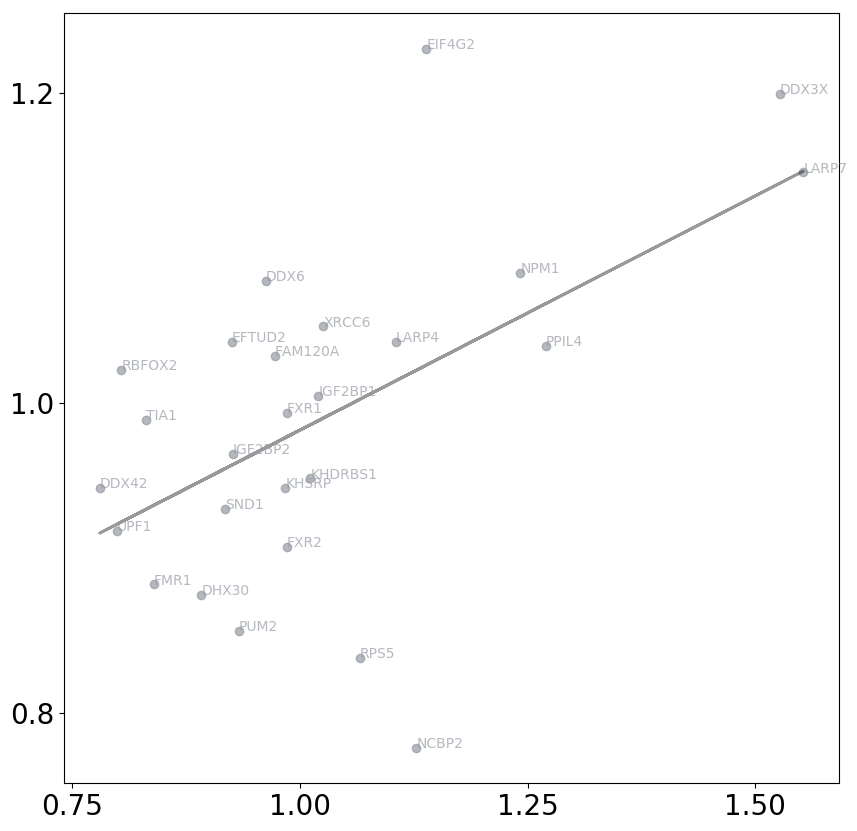

<Figure size 640x480 with 0 Axes>

In [566]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 
import numpy as np
plt.figure(figsize=(10,10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.grid(False)

rng = np.random.RandomState(0)
x = combo.column("FC(stimVSresting)")
y = (combo.column("jurkat AUC"))/(combo.column("k562 AUC"))


plt.scatter(x, y, c="#969aa3", alpha = 0.7)
#plt.scatter(x, combo.column("k562 AUC"), alpha=0.8)
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,(x*slope) + intercept, linewidth=2, linestyle='-', c= "black", alpha=0.4)


c_data = combo#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    #if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
    plt.annotate(c_data.column("geneid").item(i), data_tupules[i], color='#969aa3', alpha = 0.7) ##969aa3
print((r_value), p_value)
plt.savefig("foo.pdf")
plt.figure() #0.3876656073505631 0.002211011566847039 
            # 0.0472599068823597 0.7663121338015698
    
# 0.2497453671348317 0.05027466918693247 CYTO True, oRNAment
# 0.0064520761246146495 0.962008429024104 CYTO False, oRNAment


# 0.37361087276232263 0.006922975523875449 CYTO True, eCLIP
# 0.32702318101712574 0.06771151507131415 CYTO False, eCLIP

In [530]:
import os
rbps = [i.split(".")[0] for i in os.listdir("JSL_stim/HS copy")]
rbps.remove('')

count_data = Table().with_column("geneid", rbps).sort("geneid", descending=False)

In [531]:
stim_tbl = Table().read_table("JSL_stim/stim_overlap_8.csv")


unstim_tbl = Table().read_table("JSL_stim/unstim_overlap_8.csv")

auc = make_array()
overlap = stim_tbl
RBP = count_data
for name in tqdm(RBP.column("geneid")):
    sum_rbp = np.sum(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    len_rpb = len(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    auc = np.append(auc,sum_rbp/len_rpb )
count_data = count_data.with_column("jurkat AUC", auc)#.where(0, are.not_equal_to('nan'))

auc = make_array()
overlap = unstim_tbl
for name in tqdm(RBP.column("geneid")):
    sum_rbp = np.sum(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    len_rpb = len(overlap.with_column("Truth", [name in i for i in overlap.column("RBP")]).where("Truth", True).column("AUC Differential Binding"))
    auc = np.append(auc,sum_rbp/len_rpb)
count_data = count_data.with_column("k562 AUC", auc)#.where(0, are.not_equal_to('nan'))
count_data 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


geneid,jurkat AUC,k562 AUC
A1CF,30.5051,31.0214
A2BP1,33.9885,25.2949
ANIA04546,30.3317,31.2001
ANKHD1,27.4515,23.9621
AT1G76460TAIRG,31.42,31.7005
B52,27.0876,28.936
BOLL,32.1932,31.485
BRUNOL4,31.5874,32.2801
BRUNOL5,31.3175,33.5009
BRUNOL6,30.9833,33.4647


In [532]:
super_names = Table().read_table("JSL_stim/Uniprot/cytoplasmic_proteins.csv")

cyto = []
for geneid in tqdm(count_data.column(0)):
    super_short = super_names.with_column("Truth", [geneid in i for i in super_names.column("Gene names")]).where("Truth", True)
    if super_short.num_rows > 0:
        cyto.append(True)
    else:
        cyto.append(False)
count_data = count_data.with_column("cytoplasmic", cyto)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


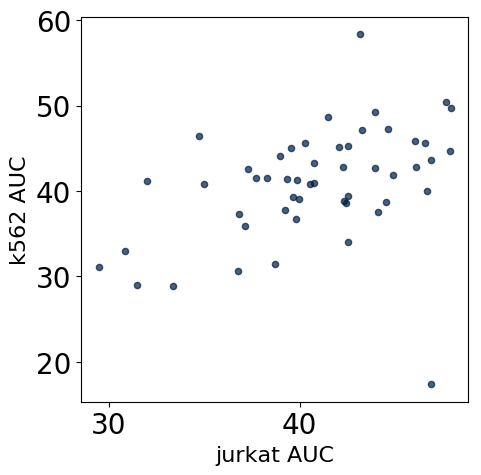

In [533]:
combo.scatter("jurkat AUC", "k562 AUC")

In [561]:
c_filtered = count_data.join("geneid", Table().read_table("JSL_stim/RBPs/utr_hits_labeled.csv"))
c_filtered = c_filtered.where("Gene", are.not_equal_to('nan'))
print(c_filtered.num_rows)
exp = Table().read_table("JSL_stim/JSL_stim_diff.csv")
exp = exp.with_column("geneid", [i.upper() for i in exp.column("geneid")])
exp = exp.with_column("resting", (exp.column("resting1") + exp.column("resting2"))/2)
exp = exp.with_column("stim", (exp.column("stim1") + exp.column("stim2"))/2)
exp = exp.where("resting", are.above(0)).where("stim", are.above(0))
exp = exp.with_column("FC(stimVSresting)", (exp.column("stim")/exp.column("resting")))
exp = exp.with_column("Log2FC(stimVSresting)", np.log2(exp.column("FC(stimVSresting)")))

combo = c_filtered.join("Gene", exp)
combo = combo.where("cytoplasmic", True).where("geneid", are.not_equal_to("RBM22")) .where("geneid", are.not_equal_to("A2BP1")).where("geneid", are.not_equal_to("ZFP36"))

144


0.10798441540523368 0.41559823015170194


<Figure size 640x480 with 0 Axes>

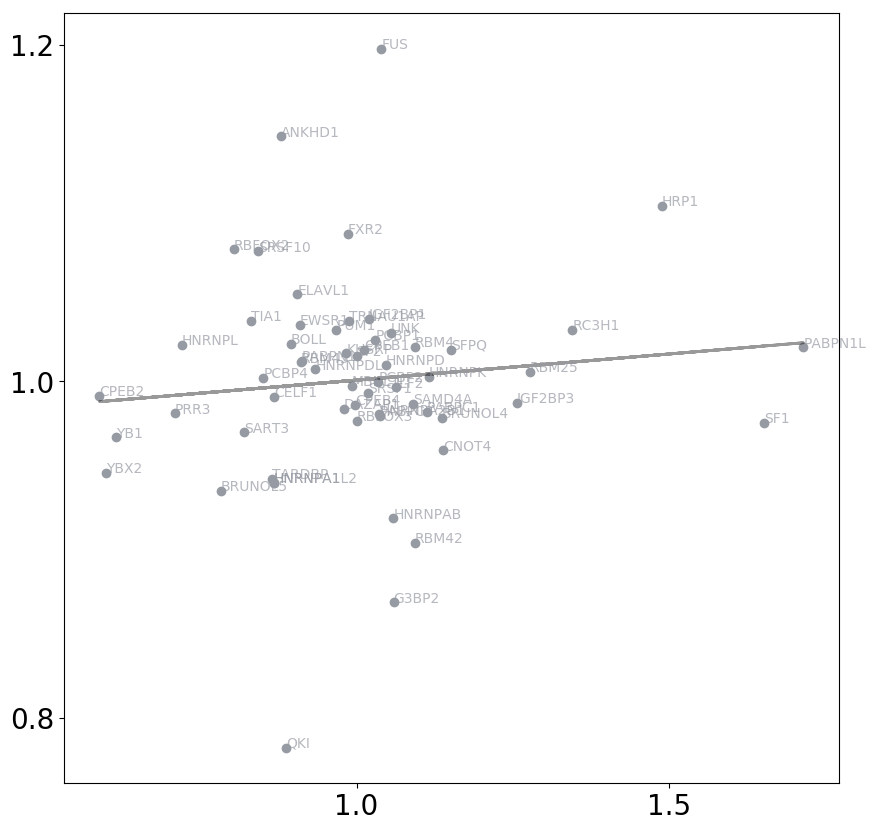

<Figure size 640x480 with 0 Axes>

In [562]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 
import numpy as np
plt.figure(figsize=(10,10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.grid(False)

rng = np.random.RandomState(0)
x = combo.column("FC(stimVSresting)")
y = (combo.column("jurkat AUC"))/(combo.column("k562 AUC"))


plt.scatter(x, y, c="#969aa3")
#plt.scatter(x, combo.column("k562 AUC"), alpha=0.8)
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,(x*slope) + intercept, linewidth=2, linestyle='-', c= "black", alpha=0.4)


c_data = combo#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    #if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
    plt.annotate(c_data.column("geneid").item(i), data_tupules[i], color='#969aa3', alpha = 0.7) ##969aa3
print((r_value), p_value)
plt.savefig("foo.pdf")
plt.figure() #0.3876656073505631 0.002211011566847039 
            # 0.0472599068823597 0.7663121338015698
    
# 0.2497453671348317 0.05027466918693247 CYTO True, oRNAment
# 0.0064520761246146495 0.962008429024104 CYTO False, oRNAment

0.20219362368368843 0.26697775890226194


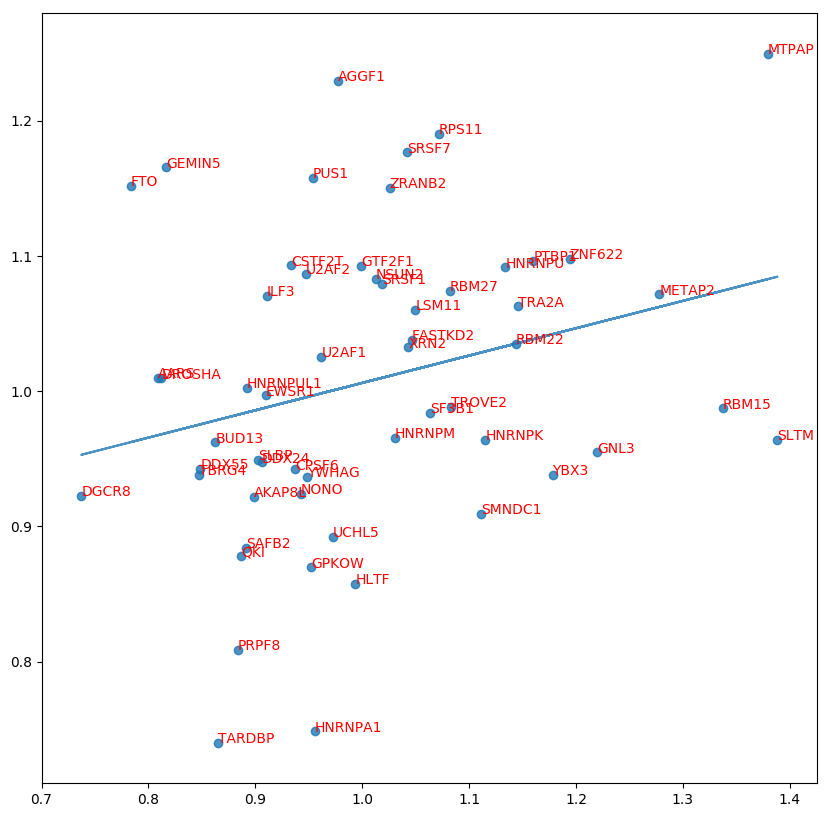

In [751]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 

import numpy as np
plt.figure(figsize=(10,10))


rng = np.random.RandomState(0)
x = combo.column("FC(stimVSresting)")
y = (combo.column("jurkat AUC"))/(combo.column("k562 AUC"))


plt.scatter(x, y, alpha=0.8)
#plt.scatter(x, combo.column("k562 AUC"), alpha=0.8)
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,(x*slope) + intercept, alpha=0.8)


c_data = combo#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    #if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
    plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')
print(slope, (r_value))
plt.savefig("foo.pdf")

0.19084692769143957 0.46487304026773907


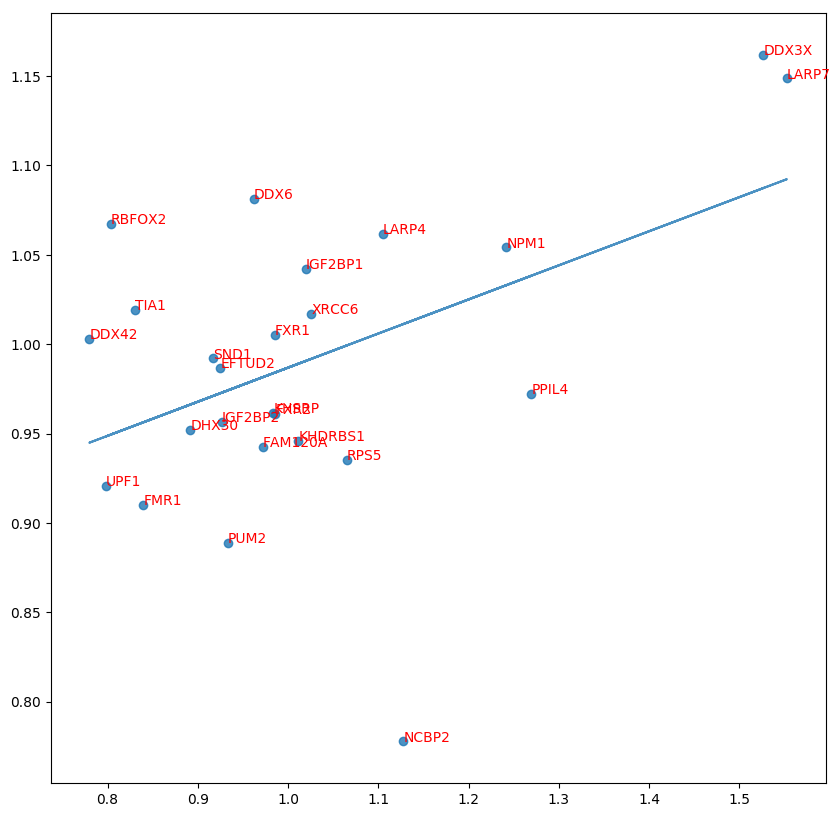

In [686]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 

import numpy as np
plt.figure(figsize=(10,10))


rng = np.random.RandomState(0)
x = combo.column("FC(stimVSresting)")
y = (combo.column("jurkat AUC"))/(combo.column("k562 AUC"))


plt.scatter(x, y, alpha=0.8)
#plt.scatter(x, combo.column("k562 AUC"), alpha=0.8)
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,(x*slope) + intercept, alpha=0.8)


c_data = combo#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    #if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
    plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')
print(slope, (r_value))
plt.savefig("foo.pdf")

0.1289565590507998 0.1950376717869871


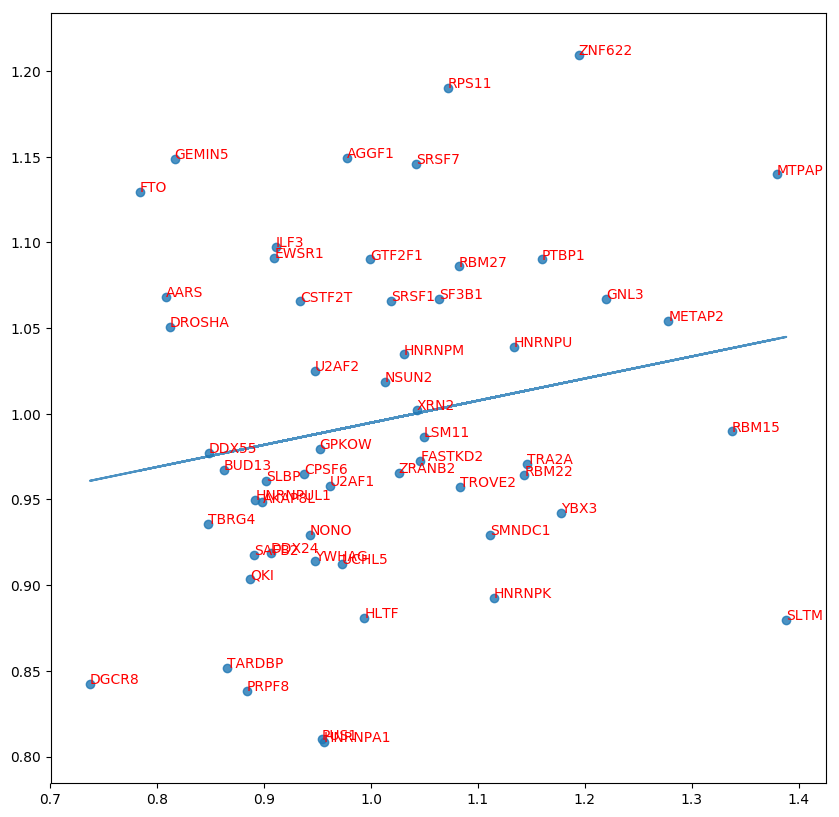

In [692]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 

import numpy as np
plt.figure(figsize=(10,10))


rng = np.random.RandomState(0)
x = combo.column("FC(stimVSresting)")
y = (combo.column("jurkat AUC"))/(combo.column("k562 AUC"))


plt.scatter(x, y, alpha=0.8)
#plt.scatter(x, combo.column("k562 AUC"), alpha=0.8)
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,(x*slope) + intercept, alpha=0.8)


c_data = combo#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    #if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
    plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')
print(slope, (r_value))
plt.savefig("foo.pdf")

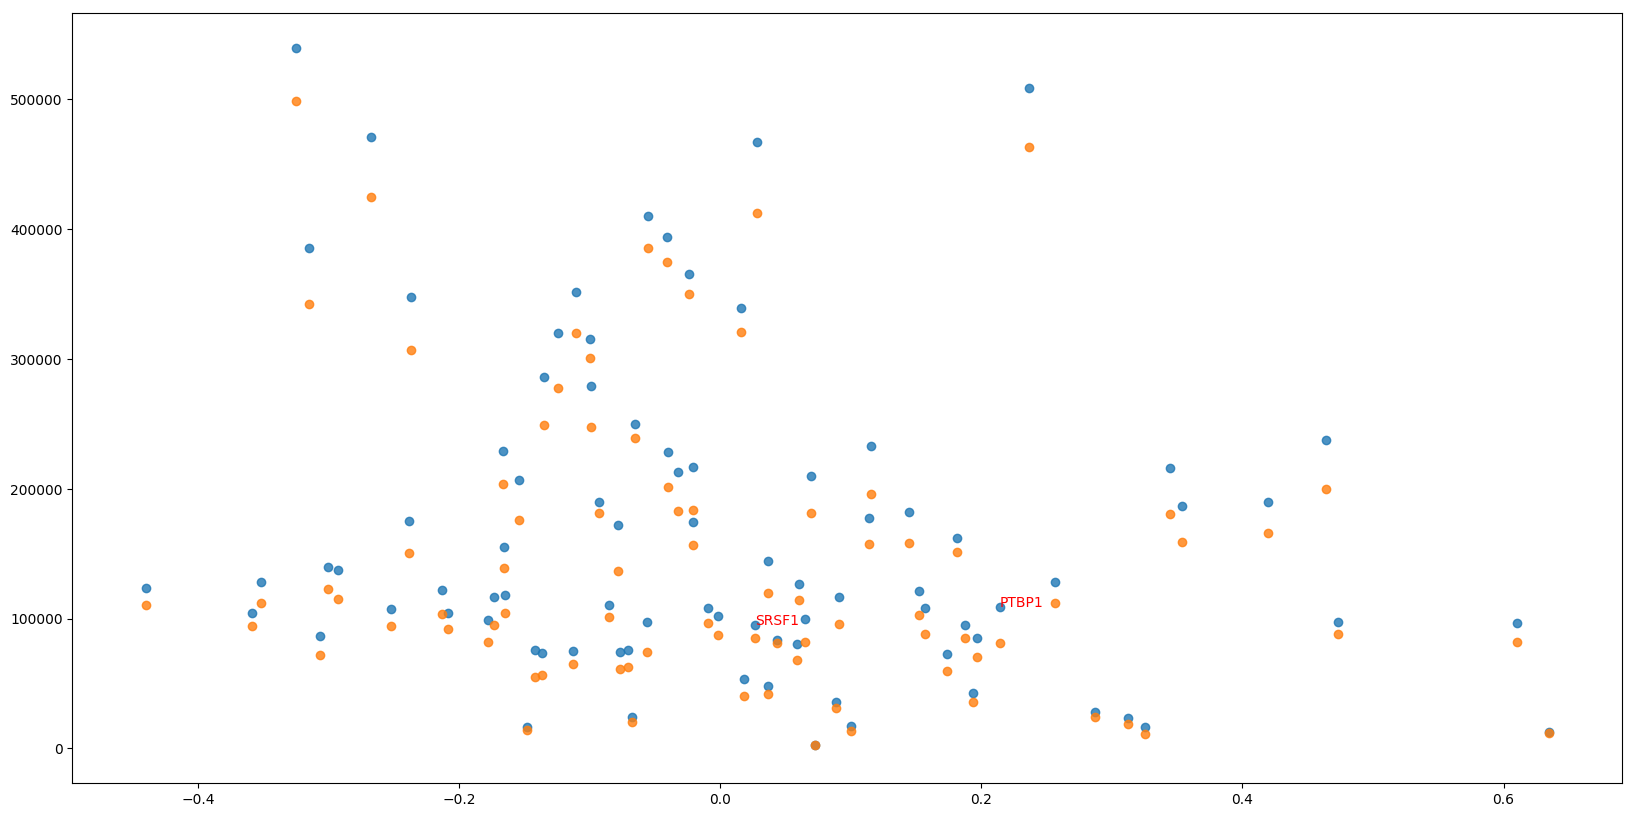

In [552]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 

import numpy as np
plt.figure(figsize=(20,10))


rng = np.random.RandomState(0)
x = combo.column("Log2FC(stimVSresting)")
y = combo.column("jurkat AUC")


plt.scatter(x, y, alpha=0.8)
plt.scatter(x, combo.column("k562 AUC"), alpha=0.8)



c_data = combo#.with_column("sz", sizes).sort("sz", descending=True).take(np.arange(10))#.with_column("truth", [int("IGF2BP" in i) + int("RBM15B" in i) for i in count_data.column("geneid")]).where("truth", are.above(0))

data_tupules = [(i, j) for i,j in zip(x, y)]

for i in np.arange(len(data_tupules)):
    if c_data.column(0).item(i) in ("RBM4  PABPN1 SF2 RALY SF1 PABPN1 SF2 SRSF1 HNRNPC PTBP1"):
        plt.annotate(c_data.column(0).item(i), data_tupules[i], color='red')

plt.savefig("foo.pdf")

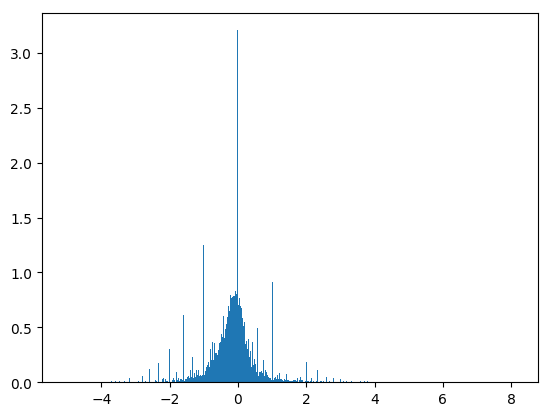

In [483]:
plt.hist(exp.column("Log2FC(stimVSresting)") , density=True, bins=500)
x = 1

In [268]:
import os
os.listdir("mir29_LSTM")

['cond1.csv',
 'miR19_KO_Upstream_targetrs_of_Il17A_.csv',
 'Picture2.csv',
 'cond2.csv',
 'Filtered_miR19_KO_Upstream_targetrs_of_Il17A_.csv',
 '.DS_Store',
 'All_genes.Ansel_Mar_0709.csv',
 'miR29_DeepCLIP_IPA_Consensus.xlsx',
 'Expansive_miR29_DeepCLIP_expression_consensus.csv',
 'Potential_il17a_Regulators',
 'cond2_sequences.csv',
 'miR29_DeepCLIP_expression_consensus.csv',
 'miR29_DeepCLIP_expression_consensus.xlsx',
 'Potential_il17a_Regulators.zip']

In [287]:
miR29 = Table.read_table("mir29_LSTM/cond2_sequences.csv")
miR29 = miR29.join("geneid", Table.read_table("miR29_LSTM/All_genes.Ansel_Mar_0709.csv"), "Gene")

exp_shift_between_15_85 = miR29.where("condition-miR29_KOvsmiR29_WT.log2FC", are.above(np.log2(1.15))).where("condition-miR29_KOvsmiR29_WT.log2FC", are.below(np.log2(1.85))).group("geneid").column("geneid")
exp_shift_above_15 = miR29.where("condition-miR29_KOvsmiR29_WT.log2FC", are.above(np.log2(1.15))).group("geneid").column("geneid")


miR29 = miR29.where("Quality Score", are.above(5))
QS_above_5 = miR29.group("geneid").column("geneid")

miR29 = miR29.with_column("Truth", [i.count("ggugcu") for i in miR29.column("RNA sequences")]).where("Truth", are.above(0))
QS_above_5_that_contains_cannonical_seed = miR29.group("geneid").column("geneid")

Th17_mir29 = miR29.where("condition-miR29_KOvsmiR29_WT.log2FC", are.above_or_equal_to(np.log2(1.85))).sort("Quality Score", descending=True)#.to_csv("mir29_Th17_LSTM/Expansive_miR29_DeepCLIP_expression_consensus.csv")



In [288]:
for i in Th17_mir29.column(0):
    print(i)

Cdkn1a
Atad2b
Rnd3
Iigp1
Ifi30
Cyth3
Slc37a2
Tet1
Rnf128


In [194]:
len(exp_shift_above_15)

3472

In [210]:
genes = Table.read_table("miR29_LSTM/All_genes.Ansel_Mar_0709.csv").group("Gene").where("count",are.below(4)).select("Gene").relabeled("Gene", "geneid")


In [278]:
genes
TRUTH_exp_shift_between_15_85 = []
TRUTH_exp_shift_above_15 = []
TRUTH_QS_above_5 = []
TRUTH_QS_above_5_that_contains_cannonical_seed = []
for gene in tqdm(genes.column(0)):
    TRUTH_exp_shift_between_15_85.append(sum([int(gene == i) for i in exp_shift_between_15_85]) > 0)
    TRUTH_exp_shift_above_15.append(sum([int(gene == i) for i in exp_shift_above_15]) > 0)
    TRUTH_QS_above_5.append(sum([int(gene == i) for i in QS_above_5]) > 0)
    TRUTH_QS_above_5_that_contains_cannonical_seed.append(sum([int(gene == i) for i in QS_above_5_that_contains_cannonical_seed]) > 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [279]:
genes = genes.with_column("Gene shows an expression shift between 15% and 85%",TRUTH_exp_shift_between_15_85) 
genes = genes.with_column("Gene shows an expression shift greater than 15%",TRUTH_exp_shift_above_15) 
genes = genes.with_column("Gene has a differentially bound site with DBE score ≥ 6",TRUTH_QS_above_5) 
genes = genes.with_column("A differentially bound site with DBE score ≥ 6 contains a cannonical motif",TRUTH_QS_above_5_that_contains_cannonical_seed) 




In [286]:
genes.to_csv("miR29_Th17_LSTM/DeepCLIP_Diagnostics_Th2.csv")

In [308]:
sup_table = Table.read_table("LSTM - miR23,24,27/cond2_repeat.csv")
sup_table.where("geneid", "Gata3")

geneid,chrom,start,stop,strands,AUC Differential Binding,RNA sequences,percentile,QS
Gata3,chr2,9858101,9858185,-,50.2023,gcauuccaaccacugaauccggaucccauuugugaauaagccauucagacucauau ...,94.4759,7
Gata3,chr2,9858275,9858320,-,26.0668,gaguuccuccgaccccuucuacuugcguuuuucgcaggagcaguau,73.2798,4
Gata3,chr2,9857898,9857929,-,25.7202,gauguccaaaugggcacacugucaguuuuguu,72.5845,4
Gata3,chr2,9857704,9857740,-,23.9821,uuccaggcugugagccugugcaaaagagauuucagau,68.7255,3
Gata3,chr2,9857486,9857507,-,13.8018,aggaacugcuuuuuuuuuuuuu,37.7706,2
Gata3,chr2,9857077,9857086,-,7.86845,uuaaaacaac,14.9341,1


In [309]:
sup_table.with_column("motif count", [i.count("ugagcc")  + i.count("cuguga")for i in sup_table.column("RNA sequences")]).where("geneid", "Gata3")

geneid,chrom,start,stop,strands,AUC Differential Binding,RNA sequences,percentile,QS,motif count
Gata3,chr2,9858101,9858185,-,50.2023,gcauuccaaccacugaauccggaucccauuugugaauaagccauucagacucauau ...,94.4759,7,0
Gata3,chr2,9858275,9858320,-,26.0668,gaguuccuccgaccccuucuacuugcguuuuucgcaggagcaguau,73.2798,4,0
Gata3,chr2,9857898,9857929,-,25.7202,gauguccaaaugggcacacugucaguuuuguu,72.5845,4,0
Gata3,chr2,9857704,9857740,-,23.9821,uuccaggcugugagccugugcaaaagagauuucagau,68.7255,3,2
Gata3,chr2,9857486,9857507,-,13.8018,aggaacugcuuuuuuuuuuuuu,37.7706,2,0
Gata3,chr2,9857077,9857086,-,7.86845,uuaaaacaac,14.9341,1,0


In [310]:
Table.read_table("LSTM - miR23,24,27/cond2_repeat.csv").where("geneid", "Gata3")

geneid,chrom,start,stop,strands,AUC Differential Binding,RNA sequences,percentile,QS
Gata3,chr2,9858101,9858185,-,50.2023,gcauuccaaccacugaauccggaucccauuugugaauaagccauucagacucauau ...,94.4759,7
Gata3,chr2,9858275,9858320,-,26.0668,gaguuccuccgaccccuucuacuugcguuuuucgcaggagcaguau,73.2798,4
Gata3,chr2,9857898,9857929,-,25.7202,gauguccaaaugggcacacugucaguuuuguu,72.5845,4
Gata3,chr2,9857704,9857740,-,23.9821,uuccaggcugugagccugugcaaaagagauuucagau,68.7255,3
Gata3,chr2,9857486,9857507,-,13.8018,aggaacugcuuuuuuuuuuuuu,37.7706,2
Gata3,chr2,9857077,9857086,-,7.86845,uuaaaacaac,14.9341,1


In [311]:
#for director in *; do for file in "$director/*"; do mv $file "$director/$director.txt"; done; done

In [312]:
#for director in *; do for file in "$director/*"; do mv $file "$director.txt"; done; done

In [313]:
#for file in *.txt; do cut -f1,1,2,3,4,5,6 "$file.txt" > "$file-1.txt" ; done

In [ ]:
for f in *; do bedtools intersect -wa -s -filenames -a Bedtools/stim.txt -b "$f" > "Bedtools/$f"; done    
cd Bedtools     for f in *; do sed -i '' "s/$/\t-$f/" $f; done

In [ ]:
bedtools intersect -wa \
    -a Bedtools/stim.txt \
    -b AARS.txt AGGF1.txt AKAP8L.txt \
    -filenames > Bedtools/stim_eCLIP_overlap.txt


In [428]:
tbl = Table().read_table("JSL_stim/merged_unstim_overlap_eCLIP.csv")
tbl = tbl.with_column("RBP",[i.split("-")[1].split(".")[0] for i in tbl.column("RNA sequences")])

In [429]:
tbl = tbl.with_column("RNA sequences",[i.split("-")[0] for i in tbl.column("RNA sequences")])

In [431]:
tbl.to_csv("JSL_stim/merged_unstim_overlap_eCLIP.csv")

In [434]:
stim_tbl = Table().read_table("JSL_stim/merged_unstim_overlap_eCLIP.csv")

In [435]:
stim_tbl = stim_tbl.with_column("AUC Differential Binding", [float(i.split(',')[0]) for i in stim_tbl.column("AUC Differential Binding")])

In [436]:
stim_tbl = stim_tbl.with_column("geneid", [(i.split(',')[0]) for i in stim_tbl.column("geneid")])

In [437]:
stim_tbl = stim_tbl.with_column("strands", [(i.split(',')[0]) for i in stim_tbl.column("strands")])

In [438]:
stim_tbl = stim_tbl.with_column("RNA sequences", [(i.split(',')[0]) for i in stim_tbl.column("RNA sequences")])

In [440]:
stim_tbl#.to_csv("JSL_stim/unstim_overlap_eCLIP.csv")

In [150]:
stim_tbl

chrom,start,stop,geneid,AUC Differential Binding,strands,RNA sequences,RBP,center
chr1,135228,135295,Al627309.1,54.6088,-,ccuucccaggccccgcuuuugacuuuuggcagccucuucaggcgcagaacuugauc ...,"AARS,DDX55,RBFOX2,METAP2,RBM15,TRA2A,MTPAP,QKI,TIA1,RBM2 ...",135261
chr1,944498,944541,Noc2l,24.5585,-,ccaaacguaucgagagcugggcugggcugggcugguguggcugct,"IGF2BP1,SLTM,PUM2,HNRNPM,RPS5,ILF3,TROVE2,IGF2BP2,AKAP8L ...",944519
chr1,1055070,1055113,Agrn,39.0446,+,ggccggagggacugcuggcccggccucccuuccguccaggcagct,"UCHL5,PTBP1,YWHAG,METAP2,FMR1,NONO,DDX6,BUD13,KHSRP,DDX4 ...",1055091
chr1,1055129,1055173,Agrn,50.1422,+,ccuagugccgagggauggacaggcgagguggcagcguggagggcut,"RPS11,AGGF1,FXR2,DROSHA,SLBP,TROVE2,RBFOX2,DHX30,AARS,RB ...",1055151
chr1,1055690,1055725,Agrn,31.2766,+,ugccuggguaucugggccuggccauggcuguguucut,"KHSRP,UPF1,U2AF2,NONO,FMR1,YBX3,YWHAG,DDX55,DDX3X,U2AF1, ...",1055707
chr1,1082185,1082200,C1orf159,11.88,-,cuggacccccaugccut,"RBFOX2,MTPAP,IGF2BP1,RBM15,DDX55,DDX42",1082192
chr1,1082361,1082422,C1orf159,79.0711,-,ccguuccagccggugcccggccaguggggaggacacagccuaggaaccagcugccu ...,"CSTF2T,UPF1,LSM11,FXR2,RBFOX2,YBX3,SRSF1",1082391
chr1,1234403,1234421,B3galt6,17.4031,+,aagaaacgggggcgggagat,"CSTF2T,RBFOX2,UPF1,SAFB2,EWSR1",1234412
chr1,1254844,1254918,Ube2j2,98.0881,-,aacccguuuuucauuuuauuagauguggucacuuagaaaugcaaacuugcugccga ...,"UPF1,FXR1,IGF2BP2,DHX30,SF3B1,AKAP8L,CSTF2T,NONO,IGF2BP1 ...",1254881
chr1,1254953,1254977,Ube2j2,27.2846,-,ggccuugugugcuggauuuguagcut,"LARP4,GEMIN5,DHX30,ZRANB2,UPF1,FTO,NCBP2,RBFOX2,UCHL5,GT ...",1254965


In [168]:
stim_tbl = Table().read_table("JSL_stim/stim_overlap_eCLIP.csv")
upper_cutoff = percentile(70, Table().read_table("JSL_stim/stim.csv").column("AUC Differential Binding"))
stim_tbl = stim_tbl.where("AUC Differential Binding", are.above_or_equal_to(upper_cutoff))
stim_tbl = stim_tbl.with_column("RBP count", [i.count(",") + 1 for i in stim_tbl.column("RBP")])
stim_tbl= stim_tbl.with_column("AUC Differential Binding", stim_tbl.column("AUC Differential Binding")/ stim_tbl.column("RBP count"))

unstim_tbl = Table().read_table("JSL_stim/unstim_overlap_eCLIP.csv")
upper_cutoff = percentile(70, Table().read_table("JSL_stim/unstim.csv").column("AUC Differential Binding"))
unstim_tbl = unstim_tbl.where("AUC Differential Binding", are.above_or_equal_to(upper_cutoff))
unstim_tbl = unstim_tbl.with_column("RBP count", [i.count(",") + 1 for i in unstim_tbl.column("RBP")])
unstim_tbl= unstim_tbl.with_column("AUC Differential Binding", unstim_tbl.column("AUC Differential Binding")/ unstim_tbl.column("RBP count"))

In [169]:
safe_stim_tbl = stim_tbl
safe_unstim_tbl = unstim_tbl

In [ ]:
for rbp in Table().read_table("JSL_stim/RBPs/utr_hits.csv").column(0):
    
    unstim_tbl = Table().read_table("JSL_stim/unstim_overlap.csv").where("RBP", are.not_equal_to('nan'))#.where("strands", "+")
    unstim_tbl = unstim_tbl.with_column("presence", [rbp in i for i in unstim_tbl.column("RBP")]).where("presence", True).drop("presence")
    unstim_tbl = unstim_tbl.with_column("center", [int(i) for i in (unstim_tbl.column("start") + unstim_tbl.column("stop"))/2])

    stim_tbl = Table().read_table("JSL_stim/stim_overlap.csv").where("RBP", are.not_equal_to('nan'))#.where("strands", "+")
    stim_tbl = stim_tbl.with_column("presence", [rbp in i for i in stim_tbl.column("RBP")]).where("presence", True).drop("presence")
    stim_tbl = stim_tbl.with_column("center", [int(i) for i in (stim_tbl.column("start") + stim_tbl.column("stop"))/2])




    covs = []

    for i in tqdm(np.arange((stim_tbl.num_rows))):
        stim_center = stim_tbl.column("center").item(i)
        stim_chrom = stim_tbl.column("chrom").item(i)
        stim_start = stim_tbl.column("start").item(i)
        stim_stop = stim_tbl.column("stop").item(i)
        stim_strand = stim_tbl.column("strands").item(i)



        short_unstim_tbl = unstim_tbl.where("chrom", stim_chrom)
        short_unstim_tbl = short_unstim_tbl.with_column("rel_pos", stim_center- short_unstim_tbl.column("center")).with_column("abs_rel_pos", [abs(i) for i in short_unstim_tbl.column("center") - stim_center]).sort("abs_rel_pos",descending=False).where("abs_rel_pos", are.below(2000))

        if short_unstim_tbl.num_rows > 0:
            for i in np.arange(short_unstim_tbl.num_rows):
                relative_stim_start = int(stim_start - short_unstim_tbl.column("center").item(i) + 2000)
                relative_stim_stop = int(stim_stop - short_unstim_tbl.column("center").item(i) + 2000)
                #print(relative_stim_start, relative_stim_stop, short_unstim_tbl.column("rel_pos").item(0))
                
                
                cov = np.zeros(4000)
                cov[relative_stim_start: relative_stim_stop + 1] = 1
                
                cov = list(cov)
                if stim_strand == "-":
                    cov.reverse()
                cov = np.asarray(cov)
                covs.append(cov)
    coverage = np.zeros(4000)
    for i in covs:
        coverage = coverage + i

    plt.figure(figsize=(20,10))



    plt.plot(np.arange(4000), coverage)
    plt.xlim(1000, 3000)
    plt.savefig("JSL_stim/Program_Change-2/" + rbp + ".pdf")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [153]:
coverage

array([ 0.,  0.,  0., ..., 12., 11., 11.])

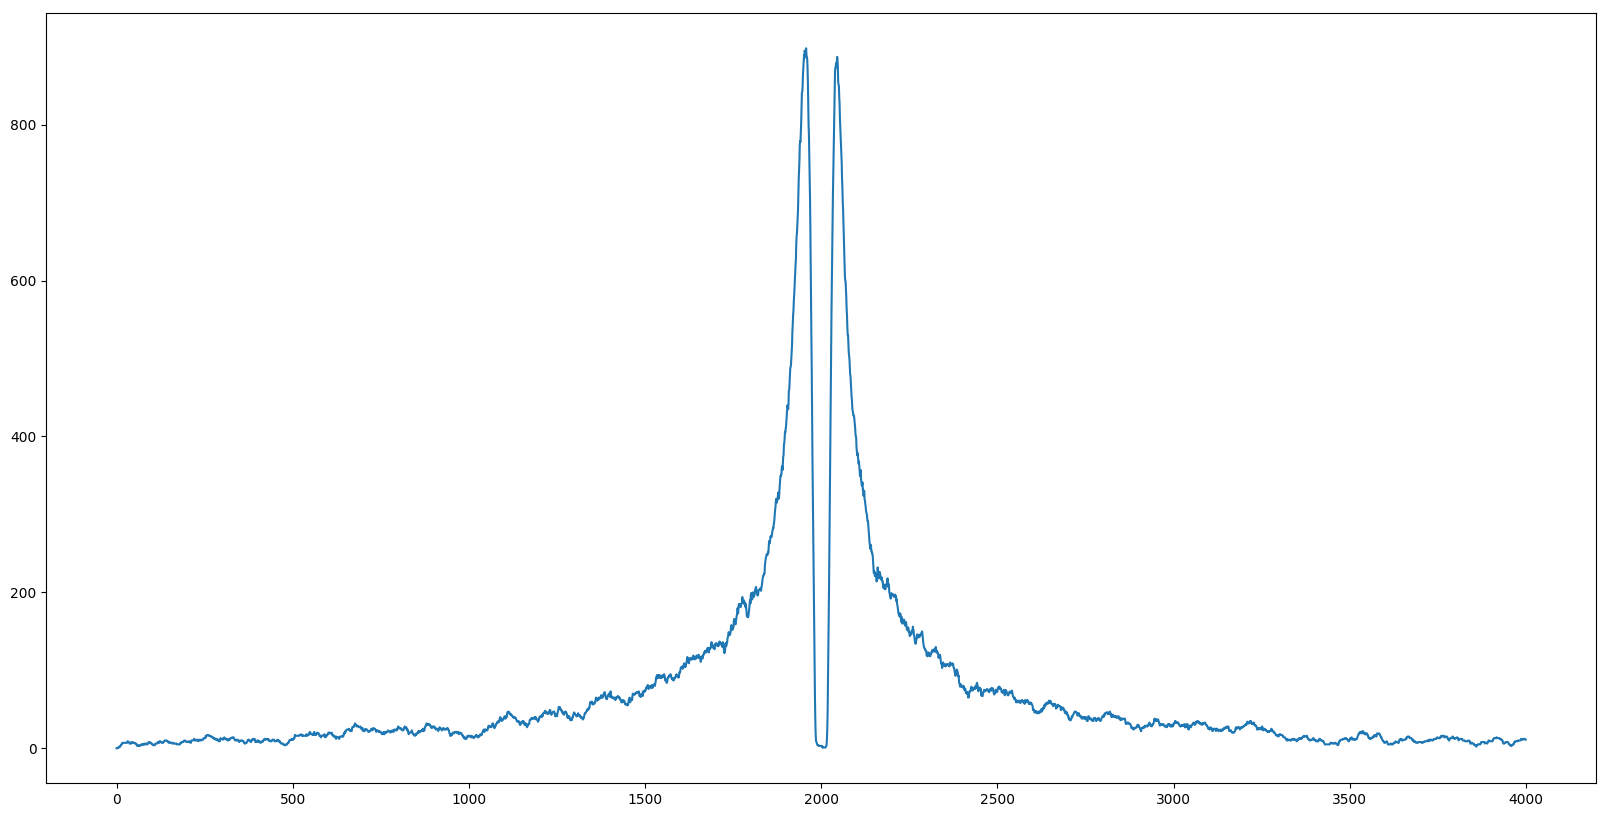

In [72]:
1254138 - 1254075

63

In [74]:
1254086 - 1254065

21

2143 2153 148


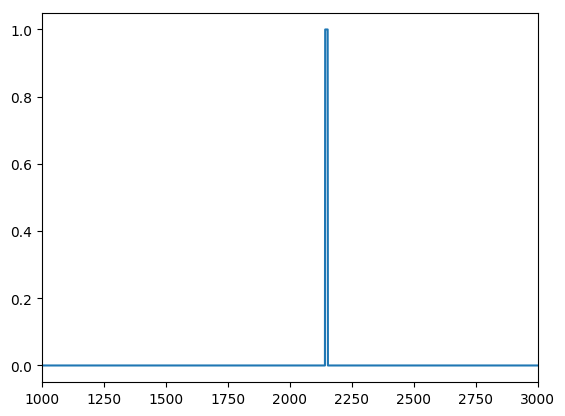

In [135]:
covs = []


i = 23

stim_center = stim_tbl.column("center").item(i)
stim_chrom = stim_tbl.column("chrom").item(i)
stim_start = stim_tbl.column("start").item(i)
stim_stop = stim_tbl.column("stop").item(i)



short_unstim_tbl = unstim_tbl.where("chrom", stim_chrom)
short_unstim_tbl = short_unstim_tbl.with_column("rel_pos", stim_center- short_unstim_tbl.column("center")).with_column("abs_rel_pos", [abs(i) for i in short_unstim_tbl.column("center") - stim_center]).sort("abs_rel_pos",descending=False).take(0)

if short_unstim_tbl.column("rel_pos").item(0) >= -2000 and short_unstim_tbl.column("rel_pos").item(0) <= 2000:
    relative_stim_start = stim_start - short_unstim_tbl.column("center").item(0) + 2000
    relative_stim_stop = stim_stop - short_unstim_tbl.column("center").item(0) + 2000
    print(relative_stim_start, relative_stim_stop, short_unstim_tbl.column("rel_pos").item(0))

    cov = np.zeros(4000)
    cov[relative_stim_start: relative_stim_stop + 1] = 1
    covs.append(cov)
    plt.plot(np.arange(4000), cov)
    plt.xlim(1000, 3000)

In [572]:
def get_depth_data(track_files,track_names,chrom,start,stop,strand,track_type):
    # for a call, this gives genomic regions from start +1 to stop
    # so to get reads at start, run start -1, stop 
    def view_region(track_file,strand,region):
        return subprocess.Popen(("samtools", "view",
                                 strand_to_flag[use_strand],
                                 "-b",track_file,
                                 region),stderr=subprocess.PIPE,stdout=subprocess.PIPE)
    mydepths = pd.DataFrame([0]*(stop-start+1),index=range(start,stop+1),columns=["depth"])
    depth_list = pd.DataFrame(0,index=range(start,stop),columns=track_names)
    strandinvert = {"+":"-","-":"+"}
    strand_to_flag = {"+":"-F 0x10",
        "-":"-f 0x10"}
    for n,track_file in enumerate(track_files):
        use_strand=strand
        region = chrom + ":" + str(start) + "-" + str(stop)
        if track_type[n] == "as":
            use_strand = strandinvert[strand]
        # Get sequences from a given region (in binary bam format still)
        ps =view_region(track_file,strand_to_flag[use_strand],region)
        sout,err = ps.communicate() # get stdout, stderr
        ## CHECK TO MAKE SURE THE REFERENCE GENOME CHROMOSOME IS FINE.
        if len(err)>0: # is there anytihn in stder?
            if b"specifies an unknown reference name" in err:
                # SWITCH REFERENCE
                temp_chrom = chrom.replace("chr","")
                region = temp_chrom + ":" + str(start) + "-" + str(stop)
                ps =view_region(track_file,strand_to_flag[use_strand],region)
                sout,err = ps.communicate()
        if len(err)>0:
            raise NameError("Unknown samtools error. Ran: samtools view %s -b %s %s | samtools depth - " % (strand_to_flag[use_strand],track_file,region))
        # Run samtools depth on the sequences retrieved
        ps2 = subprocess.Popen(("samtools", "depth","-"),stdin=subprocess.PIPE,stdout=subprocess.PIPE)
        output,err = ps2.communicate(input=sout)
        sample_depths = pd.read_table(BytesIO(output),names=["chrom","depth"],index_col=1)
        if len(sample_depths.index)>0:
            mydepths.depth = sample_depths.depth
            depth_list[track_names[n]] = sample_depths.depth
            depth_list = depth_list.fillna(value=0)  
    return depth_list
from itertools import groupby
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm


import numpy as np
from scipy import stats
from datascience import *
from scipy.signal import savgol_filter
from scipy import stats 
from scipy.integrate import simps
import subprocess
from io import BytesIO
import pandas as pd
from twobitreader import TwoBitFile




In [596]:
Table().read_table("JSL_stim/stim.csv")

geneid,chrom,start,stop,strands,AUC Differential Binding,RNA sequences
Msi2,chr17,57677029,57677058,+,344.457,gcaggugcuuucguugccaucucacucuga
C9orf69,chr9,136115164,136115347,-,250.72,guggccaccaugggccgaggucucacccaggaccccuugcucugcuccucagccuu ...
Msantd3,chr9,100450920,100451096,+,250.534,aauggccuguuuccucauuuaaccggcccuuucccaauucgcccuaagacuuuggg ...
Vps13c,chr15,61865577,61865709,-,234.648,acauauacacacauauauauacacauacaaauauacacauauauacacauacauau ...
Zbed3,chr5,77073618,77073757,-,233.617,uaguuuuccuguaauuacuaaucauuuaucuuuaauucugaguaaaauucacaaca ...
Znf783,chr7,149295724,149295918,+,233.527,ugaggggaaggccugggcuuggagauggggugcgcaggaguggcuggcuuugccuu ...
Szrd1,chr1,16397553,16397684,+,229.599,cccuuuaucugccuucacgguacuguccccuucccccagcuccucccugaccccau ...
Vps53,chr17,518816,518970,-,220.094,uacuuccugcccuaaucggagacgcugaguaagggcugggcucuaagagggcgauu ...
Trim44,chr11,35809378,35809537,+,219.834,guuuucccacugugugcugaccaucccaauuuaugaaucuucuucaaaaugacauu ...
Igf2bp1,chr17,49050976,49051138,+,217.902,ccaugcguggaguuccccuccuuucaacauugcaacaacaguaacaacaagacaac ...


In [600]:
Table().read_table("JSL_stim/stim_overlap.csv")

geneid,chrom,start,stop
Msi2,chr17,57677029,5.76771e+07
Vps13c,chr15,61865577,6.18657e+07
Szrd1,chr1,16397553,1.63977e+07
Vps53,chr17,518816,518970
Trim44,chr11,35809378,3.58095e+07
Igf2bp1,chr17,49050976,4.90511e+07
Zfp91,chr11,58620529,5.86207e+07
Mpped2,chr11,30410627,3.04107e+07
Cbx5,chr12,54241330,5.42415e+07
Smurf2,chr17,64545344,6.45455e+07


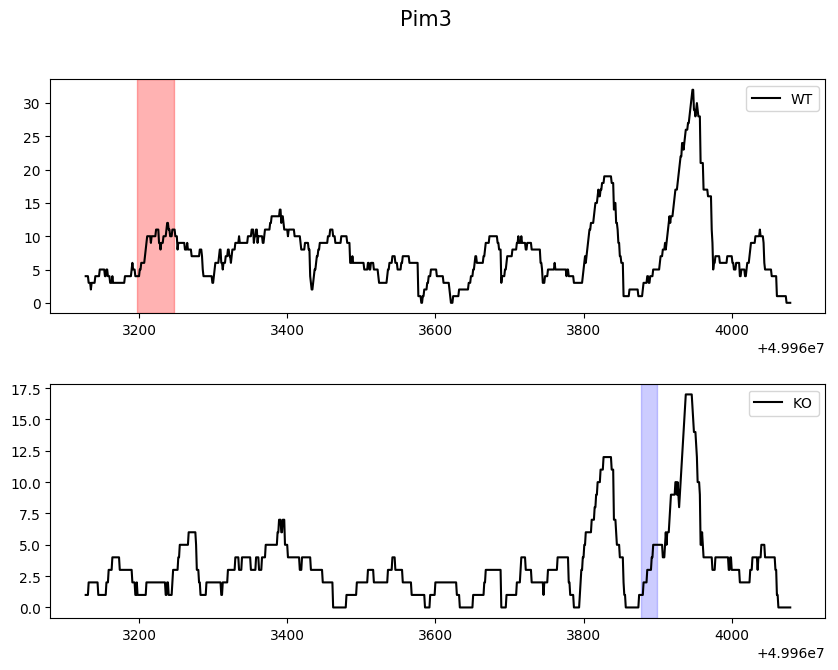

In [705]:
d_table = Table.read_table("JSL_stim/unstim_overlap_eCLIP_90_90.csv").where("geneid", "Pim3").select("start","stop")
lstm = Table().read_table("JSL_stim/stim_overlap_eCLIP_90_90.csv")#.where("QS", are.above(5))
lstm = lstm#.with_columns("loc", [(i).find("ggugcu") for i in lstm.column("RNA sequences")]).where("loc", are.above(-1))
lstm_table = lstm.where("geneid", "Pim3").select("start", "stop")

lstm_table


#f1 = "bams/miR29_KO_Th17.bam"
#f2 = "bams/miR29_WT_Th17.bam"


f1 = "bams/collapsed/jurkat_minus_merged_collapsed.bam"
f2 = "bams/collapsed/jurkat_plus_merged_collapsed.bam"

#f1 = "bams/collapsed/miR29_KO_Th2_collapsed.bam"
#f2 = "bams/collapsed/miR29_WT_Th2_collapsed.bam"


hg38_utrs = Table.read_table("Human/hg38_utrs.csv")
hg38_utrs = hg38_utrs.with_column("loc", ["Pim3" in i for i in hg38_utrs.column("GeneID")]).where("loc", True)
ref = hg38_utrs.drop("Num").row(0)

chrom, start, stop,strand = ref[0],ref[1],ref[2], ref[4]
st, stp = start, stop
depths = get_depth_data(make_array(f1, f2),make_array(f1, f2),chrom,start,stop,strand,["s", "s"])
f1_depths = depths[f1].tolist()
f2_depths = depths[f2].tolist()
reading_data = Table().with_columns("Unnamed: 0",depths.index.tolist(), f1,f1_depths, f2, f2_depths)
plt.style.use('default') 

fig1, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7))  # 2 Rows, 1 Column

ax1.plot(reading_data.column(0),reading_data.column(2), label="WT", c ="black")


ax2.plot(reading_data.column(0),reading_data.column(1), label="KO", c ="black")

for i in np.arange(d_table.num_rows):
    row = d_table.row(i)
    start,stop = row[0],row[1]
    ax2.axvspan(start, stop+1, alpha=0.2, color='blue')
for i in np.arange(lstm_table.num_rows):
    row = lstm_table.row(i)
    start,stop = row[0],row[1]
    ax1.axvspan(start, stop+1, alpha=0.3, color='red')

#ax1.axvspan(ref[1]+seq.find("acugugaa"), ref[1]+seq.find("acugugaa")+8, alpha=0.9, color='black')
ax1.legend()
ax2.legend()


fig1.suptitle("Pim3", fontsize="15")

fig1.subplots_adjust(hspace=0.3)

#start_fix = 700
#stop_fix =1100
#ax1.set_xlim(st, st+1000)
#ax2.set_xlim(st, st+1000)
#ax1.set_xticks(, minor=False)
#ax1.set_xticklabels(np.arange(0, stp-st, 200), fontdict=None, minor=False)
#plt.tight_layout()
plt.savefig("foo.pdf")

In [715]:
Table().read_table("JSL_stim/stim_overlap_eCLIP_90.csv").where("geneid", "Pim3").column("RBP")[0]

'AGGF1_K562_rep02,AKAP8L_K562_rep01,BUD13_K562_rep02,CSTF2T_K562_rep02,DDX55_K562_rep01,DDX6_K562_rep02,DGCR8_K562_rep02,FMR1_K562_rep01,FXR1_K562_rep01,FXR2_K562_rep01,HNRNPM_K562_rep02,HNRNPUL1_K562_rep01,IGF2BP2_K562_rep01,ILF3_K562_rep02,KHSRP_K562_rep02,LSM11_K562_rep01,METAP2_K562_rep02,MTPAP_K562_rep01,NONO_K562_rep02,PTBP1_K562_rep02,RBFOX2_K562_rep01,RBM15_K562_rep02,SMNDC1_K562_rep01,SND1_K562_rep01,SRSF1_K562_rep01,TIA1_K562_rep01,TRA2A_K562_rep01,TROVE2_K562_rep01,U2AF1_K562_rep02,U2AF2_K562_rep02,UPF1_K562_rep01,XRCC6_K562_rep02,YBX3_K562_rep02,YWHAG_K562_rep02,ZNF622_K562_rep02'

In [725]:
for lis in Table().read_table("JSL_stim/unstim_overlap_eCLIP_90_90.csv").where("geneid", "Pim3").column("RBP"):
    long_lis = lis.split(",")
    x = [i.split("_")[0] for i in long_lis]
    print(", ".join(x))

EIF4G2


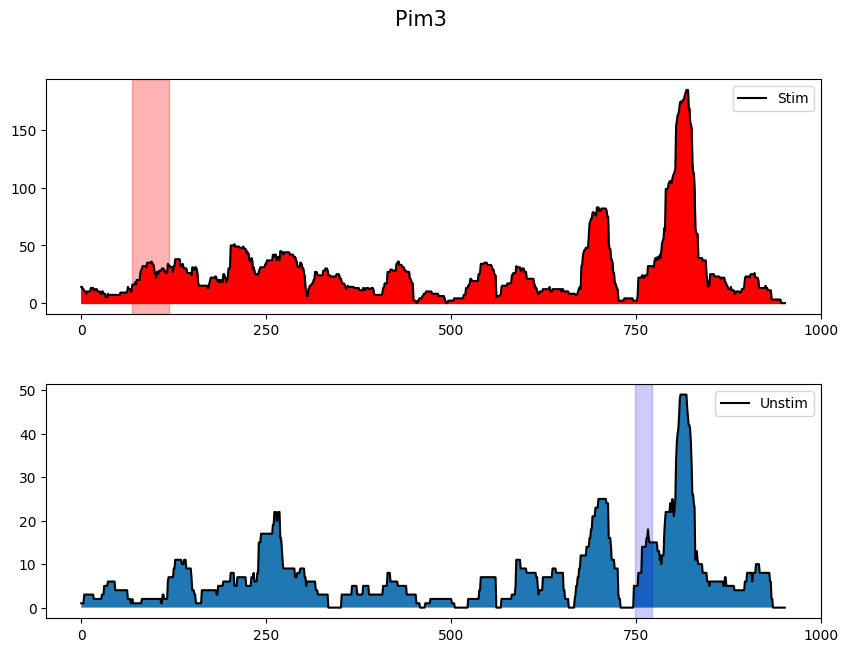

In [723]:
d_table = Table.read_table("JSL_stim/unstim_overlap_eCLIP_90_90.csv").where("geneid", "Pim3").select("start","stop")
lstm = Table().read_table("JSL_stim/stim_overlap_eCLIP_90_90.csv")#.where("QS", are.above(5))
lstm = lstm#.with_columns("loc", [(i).find("ggugcu") for i in lstm.column("RNA sequences")]).where("loc", are.above(-1))
lstm_table = lstm.where("geneid", "Pim3").select("start", "stop")

lstm_table


#f1 = "bams/miR29_KO_Th17.bam"
#f2 = "bams/miR29_WT_Th17.bam"


f1 = "bams/collapsed/jurkat_minus_merged.bam"
f2 = "bams/collapsed/jurkat_plus_merged.bam"

#f1 = "bams/collapsed/miR29_KO_Th2_collapsed.bam"
#f2 = "bams/collapsed/miR29_WT_Th2_collapsed.bam"


hg38_utrs = Table.read_table("Human/hg38_utrs.csv")
hg38_utrs = hg38_utrs.with_column("loc", ["Pim3" in i for i in hg38_utrs.column("GeneID")]).where("loc", True)
ref = hg38_utrs.drop("Num").row(0)

chrom, start, stop,strand = ref[0],ref[1],ref[2], ref[4]
st, stp = start, stop
depths = get_depth_data(make_array(f1, f2),make_array(f1, f2),chrom,start,stop,strand,["s", "s"])
depths.index = np.arange(0, (stp - st))
f1_depths = depths[f1].tolist()
f2_depths = depths[f2].tolist()
reading_data = Table().with_columns("Unnamed: 0",depths.index.tolist(), f1,f1_depths, f2, f2_depths)
plt.style.use('default') 

fig1, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7))  # 2 Rows, 1 Column

ax1.plot(reading_data.column(0),reading_data.column(2), label="Stim", c ="black")
ax1.fill_between(reading_data.column(0), 0, reading_data.column(2), color="red")

ax2.plot(reading_data.column(0),reading_data.column(1), label="Unstim", c ="black")
ax2.fill_between(reading_data.column(0), 0, reading_data.column(1))


for i in np.arange(d_table.num_rows):
    row = d_table.row(i)
    start,stop = row[0],row[1]
    ax2.axvspan(start- st, stop+1 - st, alpha=0.2, color='blue')
for i in np.arange(lstm_table.num_rows):
    row = lstm_table.row(i)
    start,stop = row[0],row[1]
    ax1.axvspan(start - st, stop+1 - st, alpha=0.3, color='red')


    
#ax1.axvspan(ref[1]+seq.find("acugugaa"), ref[1]+seq.find("acugugaa")+8, alpha=0.9, color='black')
ax1.legend()
ax2.legend()


fig1.suptitle("Pim3", fontsize="15")

fig1.subplots_adjust(hspace=0.3)

#start_fix = 700
#stop_fix =1100
#ax1.set_xlim(st, st+1000)
#ax2.set_xlim(st, st+1000)
ax1.set_xticks(np.arange(0, 1000 + 1, 250), minor=False)
ax2.set_xticks(np.arange(0, 1000 + 1, 250), minor=False)

#ax1.set_yticks(np.arange(0, 200, 50), minor=False)
#ax2.set_yticks(np.arange(0, 200, 50), minor=False)




#plt.tight_layout()
plt.savefig("foo.pdf")

In [ ]:
rbp = Table.read_table("JSL_stim/EIF4G2.csv")
rbp = rbp.where("chrom", chrom)
rbp = rbp.with_column("center", (rbp.column("start") + rbp.column("stop"))/2)
rbp = rbp.with_column("distance", np.abs(rbp.column("center") - ((start+stop)/2)))
rbp = rbp.sort("distance", descending=False).select("start", "stop").take(np.arange(4))
for i in np.arange(rbp.num_rows):
    row = rbp.row(i)
    start,stop = row[0],row[1]
    ax1.axvspan(ymin = 1, ymax = 100, xmin= start, xmax=stop+1, alpha=0.3, color='black')

In [661]:
Table().read_table("JSL_stim/stim_overlap_eCLIP.csv").where("geneid", "Pim3")

chrom,start,stop,geneid,AUC Differential Binding,strands,RNA sequences,RBP
chr22,49963197,49963246,Pim3,48.9008,+,acuuucuccugcgugggccgucuccuccugcggaagcagugaccucugact,"SMNDC1,PTBP1,LSM11,AGGF1,KHSRP,FMR1,IGF2BP2,XRCC6,TRA2A, ..."
chr22,49963280,49963290,Pim3,5.20368,+,cgcuggucccgt,"NSUN2,RBM15,U2AF1,YBX3,TRA2A"
chr22,49963335,49963354,Pim3,11.3069,+,gucgaggucccgccugcccut,GPKOW
chr22,49963451,49963485,Pim3,42.1727,+,agggucccaagcccaccucccgcccucaguccugct,"DDX55,LARP7,IGF2BP2,FXR2,YBX3,SERBP1,DHX30"
chr22,49963642,49963666,Pim3,15.8094,+,uuguugagguuauuuccucugagcat,"GPKOW,AGGF1,SND1,LIN28B,HNRNPA1,TBRG4,TIA1,GEMIN5,DGCR8, ..."
chr22,49963696,49963705,Pim3,4.94093,+,uggggaggcat,"FXR2,FMR1,CPSF6,LARP4,U2AF2,EWSR1,NCBP2,DDX55,EIF4G2,GTF ..."


In [1629]:
import os
rbps = [i.split(".")[0] for i in os.listdir("JSL_stim/eCLIP copy")]
rbps.remove('')

count_data = Table().with_column("geneid", rbps).sort("geneid", descending=False)#.where(0, "PUM2")
count_data

geneid
AARS
AGGF1
AKAP8L
BUD13
CPSF6
CSTF2T
DDX24
DDX3X
DDX42
DDX55


In [978]:
rbp = "AARS"
strand = "-"
import os





GSM2424020_ENCFF279SZJ_minus_strand_signal_of_unique_reads_hg19.bigWig
GSM2423866_ENCFF268ZWV_minus_strand_signal_of_unique_reads_hg19.bigWig


In [974]:
rbp = "IGF2BP1"
strand = "+"
import os

files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp ))
if strand == "-":
    interest_strand = "minus"
if strand == "+":
    interest_strand = "plus"
files[np.asarray([interest_strand in f for f in files])][0]


'GSM2424020_ENCFF354UTQ_plus_strand_signal_of_unique_reads_hg19.bigWig'

In [1172]:
weird_utr 

chrom,start,stop,id,Unnamed: 4,strands
chr1,158580495,158581053,NM_003126_utr3_0_0_chr1_158580496_r,nan,-


In [1258]:
good_utr 

chrom,start,stop,id,Unnamed: 4,strands
chr17,73560623,73560804,NM_001015002_utr3_9_0_chr17_73560624_f,nan,+


In [1650]:
utrs

chrom,start,stop,id,Unnamed: 4,strands
chr17,27030214,27030575,NM_001304951_utr3_0_0_chr17_27030215_r,nan,-
chr2,130806640,130806985,NR_026758_utr3_10_0_chr2_130806641_r,nan,-
chr6_mann_hap4,3023333,3023459,NR_003673_utr3_1_0_chr6_mann_hap4_3023334_r,nan,-
chr19,47123724,47124536,NM_000960_utr3_0_0_chr19_47123725_r,nan,-
chr12,55354951,55355051,"NM_001136030_utr3_1_0_chr12_55354952_r,NR_147065_utr3_2_ ...",nan,-
chr19,47885370,47885961,NM_014681_utr3_16_0_chr19_47885371_f,nan,+
chr17,17919985,17920189,NM_001130090_utr3_14_0_chr17_17919986_f,nan,+
chr4,165816567,165818679,NM_001297550_utr3_2_0_chr4_165816568_f,nan,+
chr7,132068246,132069946,NM_001105543_utr3_0_0_chr7_132068247_r,nan,-
chr17,79615324,79615785,NM_031945_utr3_2_0_chr17_79615325_f,nan,+


In [7]:
count_data = Table().read_table("GCLiPP_Data/count_data.csv")
#count_data = Table().with_columns("geneid", ["IGF2BP1", "PUM2", "TIA1"])
count_data

geneid
HNRNPU
HNRNPUL1
AARS
IGF2BP2
ILF3
KHDRBS1
KHSRP
LARP4
LARP7
LIN28B


In [ ]:
import os 
from liftover import get_lifter
import pyBigWig
import math
from scipy import stats
from scipy.stats import pearsonr

utrs = Table().read_table("GCLiPP_Data/hg19_3putr.csv")
converter = get_lifter('hg19', 'hg38')


def nucleotide_converter(chrom, start):
    new_loc =  converter[chrom][start]
    if len(new_loc) == 1:
        return int(new_loc[0][1])
    else:
        return 'nan'
    
    
import warnings
warnings.filterwarnings("ignore")

def chrom_converter(chrom, start):
    new_loc =  converter[chrom][start]
    if len(new_loc) == 1:
        return new_loc[0][0]
    else:
        return 'nan'
def normalize(lis):
    if np.std(lis) == 0:
        return [0 for val in lis]
    else:
        return ((lis - np.mean(lis))/np.std(lis))

t_statistics = list(Table().read_table("GCLiPP_Data/t_stat.csv").column(1))
rbps_run = list(Table().read_table("GCLiPP_Data/t_stat.csv").column(0))
for rbp in tqdm(count_data.column("geneid")):
    eCLIP_correlations = []
    mock_correlations = []
    IDs = []
    gclipp_file_bw_plus = pyBigWig.open("bams/collapsed/jurkat_all_plus.bw") 
    gclipp_file_bw_minus = pyBigWig.open("bams/collapsed/jurkat_all_minus.bw")
    
    
    interest_strand = "minus"
    files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp ))
    eCLIP_file_minus = "GCLiPP_Data/encore/" + rbp + "/"+ files[np.asarray([interest_strand in f for f in files])][0]
    files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp + "_eCLIP_mock_input"))
    eCLIP_mock_minus = "GCLiPP_Data/encore/" + rbp + "_eCLIP_mock_input" + "/" + files[np.asarray([interest_strand in f for f in files])][0]

    eCLIP_file_bw_minus = pyBigWig.open(eCLIP_file_minus)
    eCLIP_mock_bw_minus = pyBigWig.open(eCLIP_mock_minus)
    
    
    interest_strand = "plus"
    files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp ))    
    eCLIP_file_plus = "GCLiPP_Data/encore/" + rbp + "/"+ files[np.asarray([interest_strand in f for f in files])][0]
    files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp + "_eCLIP_mock_input"))
    eCLIP_mock_plus = "GCLiPP_Data/encore/" + rbp + "_eCLIP_mock_input" + "/" + files[np.asarray([interest_strand in f for f in files])][0]

    eCLIP_file_bw_plus = pyBigWig.open(eCLIP_file_plus)
    eCLIP_mock_bw_plus = pyBigWig.open(eCLIP_mock_plus)
    
    for i in tqdm(np.arange(utrs.num_rows)):
        chrom = utrs.column("chrom").item(i)
        start = utrs.column("start").item(i)
        stop = utrs.column("stop").item(i)
        strand = utrs.column("strands").item(i)
        ID = utrs.column("id").item(i)
        
        super_table = Table().with_columns("nucleotide_hg19", np.arange(start, stop +1))
        super_table = super_table.with_columns("nucleotide_hg38", [nucleotide_converter(chrom, old_nuc) for old_nuc in super_table.column("nucleotide_hg19")])
        
        if super_table.where("nucleotide_hg38", are.not_equal_to('nan')).num_rows > 0:
            
            super_table = super_table.where("nucleotide_hg38", are.not_equal_to('nan'))
            super_table = super_table.with_column("nucleotide_hg38", [int(i) for i in super_table.column("nucleotide_hg38")])
            new_chrom = chrom_converter(chrom, start)
            new_start = min(super_table.column("nucleotide_hg38"))
            new_stop = max(super_table.column("nucleotide_hg38"))
            if new_chrom != 'nan':
                if strand == "-":
                    gclipp = gclipp_file_bw_minus
                if strand == "+":
                    gclipp = gclipp_file_bw_plus
                gclipp_vals = [0.0 if math.isnan(x) else x for x in gclipp.values(new_chrom, new_start, new_stop + 1)]
                gCLiPP_tbl = Table().with_columns("nucleotide_hg38", np.arange(new_start, new_stop + 1), "gclipp", gclipp_vals)
                super_table = super_table.join("nucleotide_hg38", gCLiPP_tbl)
                super_table = super_table.with_column("gclipp", normalize(super_table.column("gclipp")))
                if strand == "-":
                    eCLIP_file_bw = eCLIP_file_bw_minus
                    eCLIP_mock_bw = eCLIP_mock_bw_minus
                if strand == "+":
                    eCLIP_file_bw = eCLIP_file_bw_plus
                    eCLIP_mock_bw = eCLIP_mock_bw_plus
    
                if chrom in list(eCLIP_file_bw.chroms()) and chrom in list(eCLIP_mock_bw.chroms()):
                    #print(chrom, start, stop)
                    if strand == "-":
                        multiplier = -1
                    else:
                        multiplier = 1
                    eCLIP_data = Table().with_columns("nucleotide_hg19", np.arange(start, stop + 1), "eCLIP", normalize([0.0 if math.isnan(x) else multiplier*x for x in eCLIP_file_bw.values(chrom, start, stop + 1)]))
                    eCLIP_data = eCLIP_data.with_column("eCLIP_mock", normalize([0.0 if math.isnan(x) else multiplier*x for x in eCLIP_mock_bw.values(chrom, start, stop + 1)]))

                    super_table = super_table.join("nucleotide_hg19", eCLIP_data)

                    corr_GCLiPP_eCLIP, _ = pearsonr(super_table.column("gclipp"), super_table.column("eCLIP"))
                    corr_GCLiPP_eCLIP_MOCK, _ = pearsonr(super_table.column("gclipp"), super_table.column("eCLIP_mock"))
                    eCLIP_correlations.append(corr_GCLiPP_eCLIP)
                    mock_correlations.append(corr_GCLiPP_eCLIP_MOCK)
                    IDs.append(ID)
                    
    correlations = Table().with_columns("eCLIP-GCLiP", eCLIP_correlations, "control-GCLiP9", mock_correlations, "id", IDs)
    correlations = correlations.where(0, are.above(-10000000)).where(1, are.above(-10000000))
    #correlations = correlations.where(0, are.above(-10000000)).where(1, are.above(-10000000))
    correlations.to_csv("GCLiPP_Data/correlations/"+rbp+".csv")
    


    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.style.use('default') 

    import numpy as np
    plt.figure(figsize=(10,5))

    import seaborn as sns
    df = sns.load_dataset('iris')

    # Basic 2D density plot
    sns.set_style("white")
    #sns.kdeplot(correlations.column(0),correlations.column(1))
    #sns.plt.show()

    # Custom it with the same argument as 1D density plot
    #sns.kdeplot(correlations.column(0),correlations.column(1), cmap="Reds", shade=True, bw=.15)

    # Some features are characteristic of 2D: color palette and wether or not color the lowest range
    sns.kdeplot(correlations.column(0),correlations.column(1), n_levels=8, gridsize=300, cmap="inferno", shade=True, shade_lowest=False)
    plt.plot(np.arange(-.4,.6,0.2 ), np.arange(-.4,.6,0.2 ), lw=1, c="#b5b5b5" ,ls="dashed", dashes=(5, 10))#sns.plt.show()
    plt.xlim(-.5, .5)
    plt.ylim(-.5, .5)
    plt.savefig("GCLiPP_Data/graphs/"+rbp+".pdf")

    t,p = stats.ttest_rel(correlations.column(0),correlations.column(1))
    t_statistics.append(t)
    rbps_run.append(rbp)
    
    Table().with_columns("rbp",rbps_run, "t", t_statistics).to_csv("GCLiPP_Data/t_stat.csv")


In [1800]:
t_statistics #["IGF2BP1", "PUM2", "TIA1"]

[5.271626857201912, -4.486053563177871, 9.60384359166984]

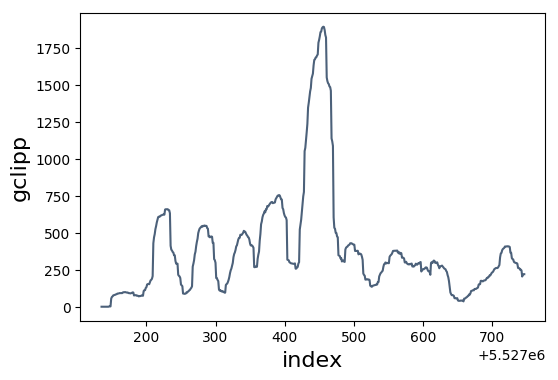

In [1788]:
new_chrom = "chr7"
new_start = 5527135
new_stop = 5527747

gCLiPP_tbl = get_depth_data(make_array("bams/collapsed/jurkat_all.bam"),make_array("gclipp"),new_chrom,int(new_start),int(new_stop)+1,"-",["s"])
#gCLiPP_tbl.index = np.arange(new_start, new_stop)
gCLiPP_signal = gCLiPP_tbl["gclipp"].tolist()
Table.from_df(gCLiPP_tbl, keep_index=True).plot(0,1)

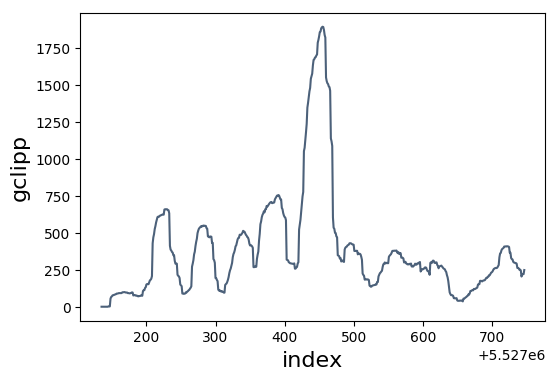

In [1789]:
eCLIP_file_bw_plus = pyBigWig.open("bams/collapsed/jurkat_all_minus.bw") # minus strand

vals = [0.0 if math.isnan(x) else x for x in eCLIP_file_bw_plus.values(new_chrom, new_start, new_stop + 1)]
Table().with_columns("index", np.arange(new_start, new_stop+1), "gclipp", vals).plot(0,1)

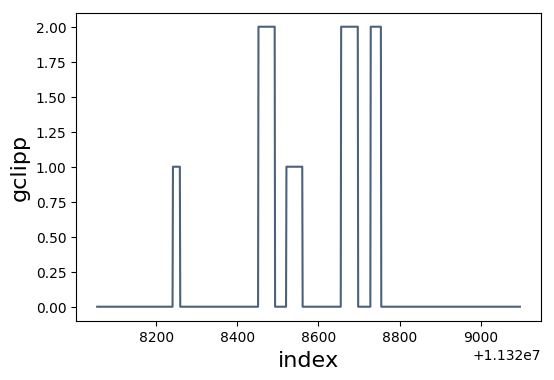

In [1793]:
new_chrom = "chr10"
new_start = 11328054
new_stop = 11329097

gCLiPP_tbl = get_depth_data(make_array("bams/collapsed/jurkat_all.bam"),make_array("gclipp"),new_chrom,int(new_start),int(new_stop)+1,"-",["s"])
#gCLiPP_tbl.index = np.arange(new_start, new_stop)
gCLiPP_signal = gCLiPP_tbl["gclipp"].tolist()
Table.from_df(gCLiPP_tbl, keep_index=True).plot(0,1)

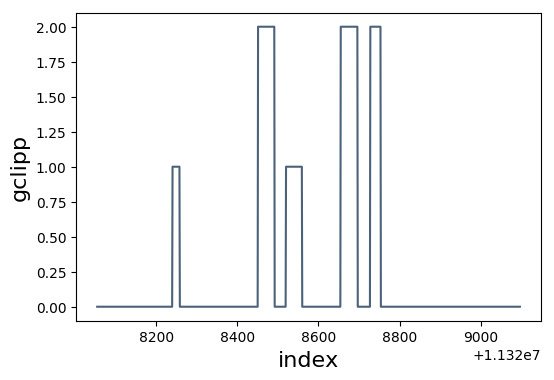

In [1794]:
eCLIP_file_bw_plus = pyBigWig.open("bams/collapsed/jurkat_all_minus.bw") # plus strand

vals = [0.0 if math.isnan(x) else x for x in eCLIP_file_bw_plus.values(new_chrom, new_start, new_stop + 1)]
Table().with_columns("index", np.arange(new_start, new_stop+1), "gclipp", vals).plot(0,1)

In [1594]:
correlations = Table().with_columns("eCLIP-GCLiP", eCLIP_correlations, "control-GCLiP", mock_correlations)
#correlations = correlations.where(0, are.above(-10000000)).where(1, are.above(-10000000))
correlations.to_csv("GCLiPP_Data/Pum2.csv")

In [1660]:
correlations = Table().read_table("GCLiPP_Data/Pum2.csv")
correlations = correlations.where(0, are.above(-10000000)).where(1, are.above(-10000000))


correlations

eCLIP-GCLiP,control-GCLiP
-0.0469794,-0.0473511
0.160283,-0.0185166
-0.209608,0.446078
-0.0989975,0.145418
-0.0607499,-0.19959
0.337438,0.0736579
-0.0716123,-0.476907
0.786897,-0.0480196
0.0175364,0.324653
0.18991,-0.0778557


In [1597]:
correlations = correlations.where(0, are.above(-10000000)).where(1, are.above(-10000000))

In [1661]:
correlations = correlations.with_column("truth", [i>j for i,j in zip(correlations.column("eCLIP-GCLiP"), correlations.column("control-GCLiP"))])
correlations.where("truth", True).num_rows/ correlations.num_rows


0.4749157733537519

In [1662]:
from scipy import stats
t,p = stats.ttest_rel(correlations.column(0),correlations.column(1))
t

-4.548491345686342

In [1599]:
from scipy import stats
stats.ttest_rel(correlations.column(0),correlations.column(1))

Ttest_relResult(statistic=-4.548491345686342, pvalue=5.442077110035377e-06)

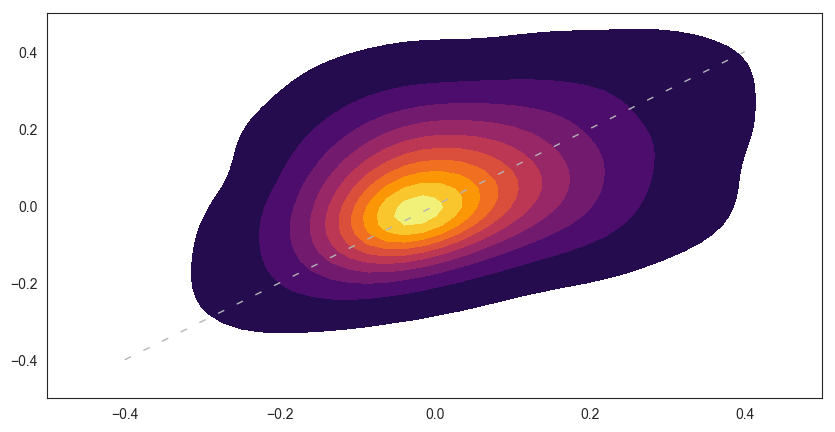

In [1673]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 

import numpy as np
plt.figure(figsize=(10,5))

import seaborn as sns
df = sns.load_dataset('iris')
 
# Basic 2D density plot
sns.set_style("white")
#sns.kdeplot(correlations.column(0),correlations.column(1))
#sns.plt.show()
 
# Custom it with the same argument as 1D density plot
#sns.kdeplot(correlations.column(0),correlations.column(1), cmap="Reds", shade=True, bw=.15)
 
# Some features are characteristic of 2D: color palette and wether or not color the lowest range
sns.kdeplot(correlations.column(0),correlations.column(1), gridsize=100, cmap="inferno", shade=True, shade_lowest=False)
plt.plot(np.arange(-.4,.6,0.2 ), np.arange(-.4,.6,0.2 ), lw=1, c="#b5b5b5" ,ls="dashed", dashes=(5, 10))#sns.plt.show()
plt.xlim(-.5, .5)
plt.ylim(-.5, .5)
plt.savefig("foo.pdf")

In [1635]:
from scipy import stats
stats.ttest_rel(correlations.column(0),correlations.column(1)) 

Ttest_relResult(statistic=-4.548491345686342, pvalue=5.442077110035377e-06)

In [1276]:
normalize([0.0 if math.isnan(x) else x for x in eCLIP_file_bw.values(chrom, start, stop + 1)])

RuntimeError: Invalid interval bounds!

In [1442]:
hg38

Chrom,Start,Stop,GeneID,Num,Strand,transcript id,info,truth
chr2,174072447,174075425,Ola1-2545892,"ORF,UTR",-,"ENST00000284719.3,ENST00000428402.2",Obg-like ATPase 1 [Source:HGNC Symbol;Acc:28833],True


In [1566]:
utrs = Table().read_table("GCLiPP_Data/hg19&hg38_3putr.csv")
hg38 = Table().read_table("Human/hg38_utrs.csv")
hg38 = hg38.with_column("truth", ["Ostc" in j for j in hg38.column("GeneID")]).where("truth", True)
hg38_chrom  =hg38.column("Chrom").item(0)
hg38_center =int((hg38.column("Start").item(0) + hg38.column("Stop").item(0))/2)
print(hg38.column("Strand").item(0))

utrs = utrs.where("chrom", hg38_chrom)
utrs = utrs.with_column("dist", [abs(int(i) - hg38_center) for i in ((utrs.column("str") + utrs.column("stp"))/2)]).sort("dist", descending=False).take(0)
#utrs = utrs.with_column("start", [174939500+ 200])
#utrs = utrs.with_column("stop", [174940153])


utrs

+


chrom,start,stop,id,strands,chr,str,stp,stran,dist
chr4,109588413,109588978,"NM_001267818_utr3_4_0_chr4_109588414_f,NM_021227_utr3_3_ ...",+,chr4,108667257,108667822,+,10


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


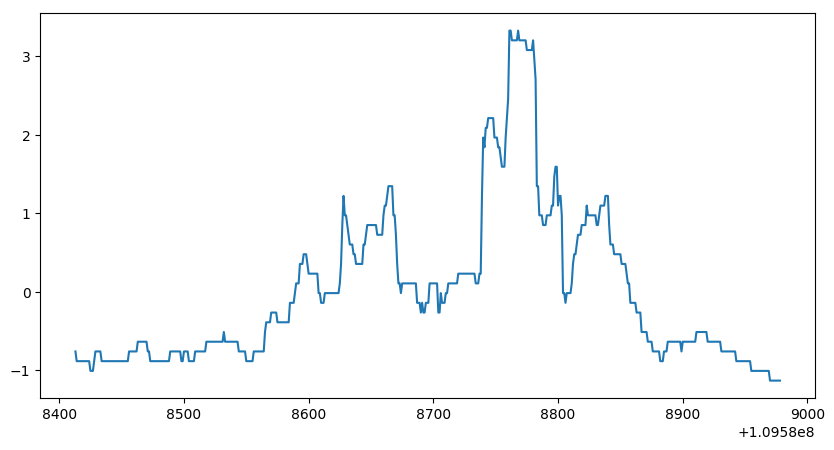

In [1574]:
import os 
from liftover import get_lifter
import pyBigWig
import math
from scipy.stats import pearsonr

#utrs = Table().read_table("GCLiPP_Data/hg19_3putr.csv").where("strands", "-").sample(1)
converter = get_lifter('hg19', 'hg38')


def nucleotide_converter(chrom, start):
    new_loc =  converter[chrom][start]
    if len(new_loc) == 1:
        return int(new_loc[0][1])
    else:
        return 'nan'
    
    
#import warnings
#warnings.filterwarnings("ignore")

def chrom_converter(chrom, start):
    new_loc =  converter[chrom][start]
    if len(new_loc) == 1:
        return new_loc[0][0]
    else:
        return 'nan'
def normalize(lis):
    if np.std(lis) == 0:
        return [0 for val in lis]
    else:
        return ((lis - np.mean(lis))/np.std(lis))

t_statistics = []
for rbp in count_data.column("geneid"):
    eCLIP_correlations = []
    mock_correlations = []
    for i in tqdm(np.arange(utrs.num_rows)):
        chrom = utrs.column("chrom").item(i)
        start = utrs.column("start").item(i)
        stop = utrs.column("stop").item(i)
        strand = utrs.column("strands").item(i)
        
        super_table = Table().with_columns("nucleotide_hg19", np.arange(start, stop +1))
        super_table = super_table.with_columns("nucleotide_hg38", [nucleotide_converter(chrom, old_nuc) for old_nuc in super_table.column("nucleotide_hg19")])
        
        if super_table.where("nucleotide_hg38", are.not_equal_to('nan')).num_rows > 0:
            super_table = super_table.where("nucleotide_hg38", are.not_equal_to('nan'))
            super_table = super_table.with_column("nucleotide_hg38", [int(i) for i in super_table.column("nucleotide_hg38")])
            new_chrom = chrom_converter(chrom, start)
            new_start = min(super_table.where("nucleotide_hg38", are.not_equal_to('nan')).column("nucleotide_hg38"))
            new_stop = max(super_table.where("nucleotide_hg38", are.not_equal_to('nan')).column("nucleotide_hg38"))
            if new_chrom != 'nan':
                gCLiPP_tbl = get_depth_data(make_array("bams/collapsed/jurkat_all.bam", "bams/collapsed/jurkat_all.bam"),make_array("bams/collapsed/jurkat_all.bam", "2"),new_chrom,int(new_start),int(new_stop)+1,strand,["s", "s"])
                #gCLiPP_tbl.index = np.arange(new_start, new_stop)
                gCLiPP_signal = gCLiPP_tbl["bams/collapsed/jurkat_all.bam"].tolist()

                super_table = super_table.join("nucleotide_hg38", Table.from_df(gCLiPP_tbl, keep_index=True).relabeled("index", "nucleotide_hg38").relabeled("bams/collapsed/jurkat_all.bam", "gclipp").drop("2"))
                super_table = super_table.with_column("gclipp", normalize(super_table.column("gclipp")))
                files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp ))
                if strand == "-":
                    interest_strand = "minus"
                if strand == "+":
                    interest_strand = "plus"
                eCLIP_file = "GCLiPP_Data/encore/" + rbp + "/"+ files[np.asarray([interest_strand in f for f in files])][0]

                files = np.asarray(os.listdir("GCLiPP_Data/encore/" + rbp + "_eCLIP_mock_input"))
                eCLIP_mock = "GCLiPP_Data/encore/" + rbp + "_eCLIP_mock_input" + "/" + files[np.asarray([interest_strand in f for f in files])][0]

                eCLIP_file_bw = pyBigWig.open(eCLIP_file)
                eCLIP_mock_bw = pyBigWig.open(eCLIP_mock)
                if chrom in list(eCLIP_file_bw.chroms()) and chrom in list(eCLIP_mock_bw.chroms()):
                    #print(chrom, start, stop)
                    
                    if strand == "-":
                        multiplier = -1
                    else:
                        multiplier = 1
                    eCLIP_data = Table().with_columns("nucleotide_hg19", np.arange(start, stop + 1), "eCLIP", normalize([0.0 if math.isnan(x) else multiplier*x for x in eCLIP_file_bw.values(chrom, start, stop + 1)]))
                    eCLIP_data = eCLIP_data.with_column("eCLIP_mock", normalize([0.0 if math.isnan(x) else multiplier*x for x in eCLIP_mock_bw.values(chrom, start, stop + 1)]))

                    super_table = super_table.join("nucleotide_hg19", eCLIP_data)

                    corr_GCLiPP_eCLIP, _ = pearsonr(super_table.column("gclipp"), super_table.column("eCLIP"))
                    corr_GCLiPP_eCLIP_MOCK, _ = pearsonr(super_table.column("gclipp"), super_table.column("eCLIP_mock"))
                    eCLIP_correlations.append(corr_GCLiPP_eCLIP)
                    mock_correlations.append(corr_GCLiPP_eCLIP_MOCK)
                    %matplotlib inline
                    import matplotlib.pyplot as plt
                    plt.style.use('default') 
                    plt.figure(figsize=(10,5))
                    plt.plot(super_table.column(0), super_table.column(2))
                    plt.figure()
                    %matplotlib inline
                    import matplotlib.pyplot as plt
                    plt.style.use('default') 
                    plt.figure(figsize=(10,5))
                    plt.plot(super_table.column(0), super_table.column(3))
                    plt.plot(super_table.column(0), super_table.column(4))
                    plt.figure()
                    %matplotlib inline
                    import matplotlib.pyplot as plt
                    plt.style.use('default') 
                    plt.figure(figsize=(10,5))
                    plt.plot(super_table.column(0), super_table.column(4))

In [1575]:
corr_GCLiPP_eCLIP

-0.21915084070053942

In [1576]:
corr_GCLiPP_eCLIP_MOCK

0.08267169845326952

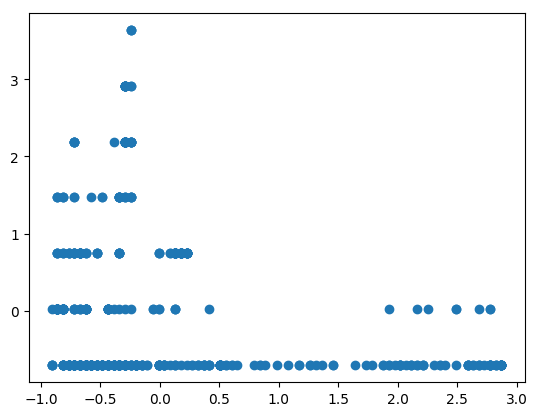

In [1577]:
plt.scatter(super_table.column(2), super_table.column(3))

<Figure size 640x480 with 0 Axes>

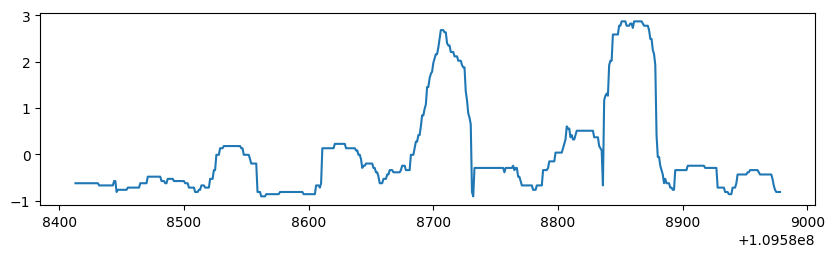

<Figure size 640x480 with 0 Axes>

In [1578]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 
plt.figure(figsize=(10,2.5))
plt.plot(super_table.column(0), super_table.column(2))
plt.figure()

<Figure size 640x480 with 0 Axes>

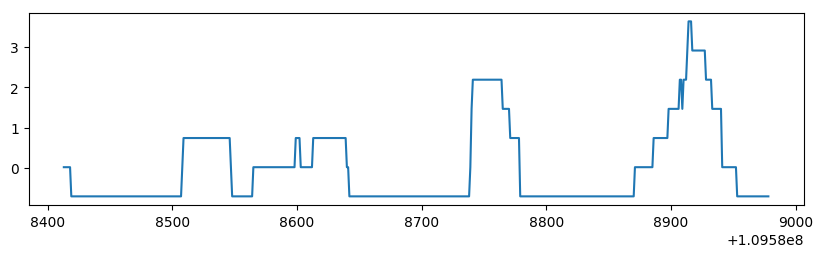

<Figure size 640x480 with 0 Axes>

In [1579]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 
plt.figure(figsize=(10,2.5))
plt.plot(super_table.column(0), super_table.column(3))
plt.figure()

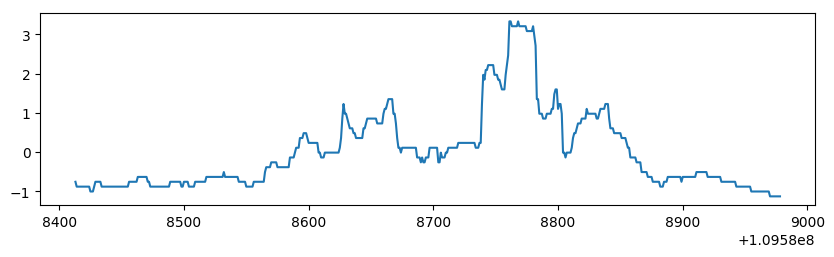

In [1580]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default') 
plt.figure(figsize=(10,2.5))
plt.plot(super_table.column(0), super_table.column(4))

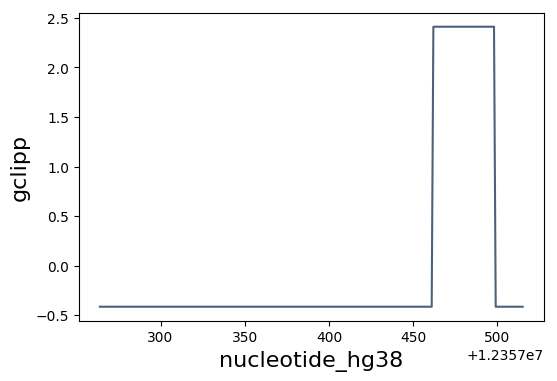

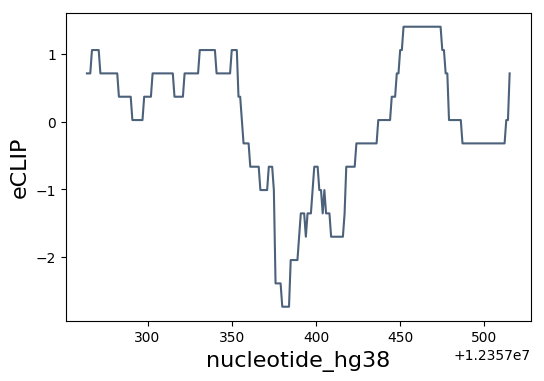

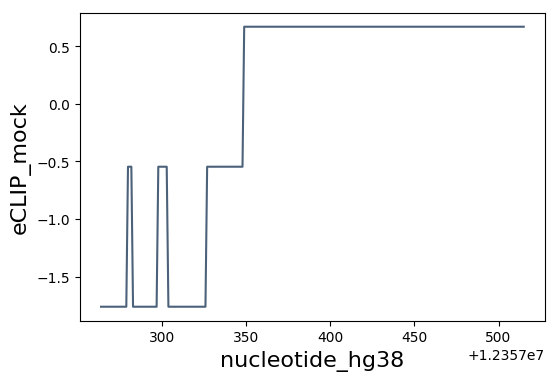

In [1271]:
super_table.plot(1, 2)
super_table.plot(1, 3)
super_table.plot(1, 4)

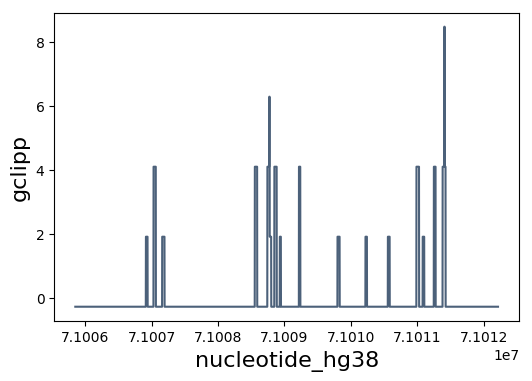

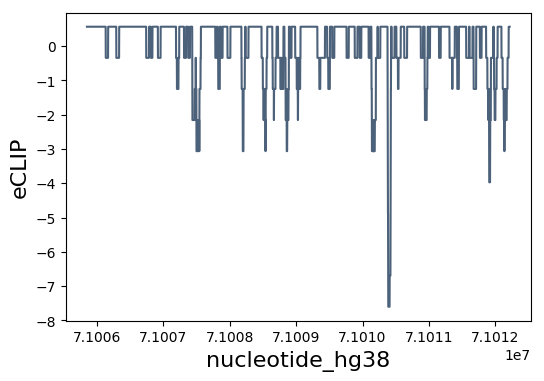

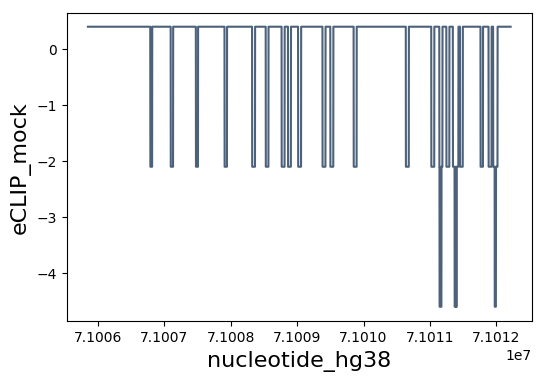

In [1135]:
super_table.plot(1, 2)
super_table.plot(1, 3)
super_table.plot(1, 4)

In [1108]:
super_table#.column("eCLIP")

nucleotide_hg19,nucleotide_hg38,gclipp,eCLIP,eCLIP_mock
15166900,15056089,nan,nan,nan
15166901,15056090,nan,nan,nan
15166902,15056091,nan,nan,nan
15166903,15056092,nan,nan,nan
15166904,15056093,nan,nan,nan
15166905,15056094,nan,nan,nan
15166906,15056095,nan,nan,nan
15166907,15056096,nan,nan,nan
15166908,15056097,nan,nan,nan
15166909,15056098,nan,nan,nan


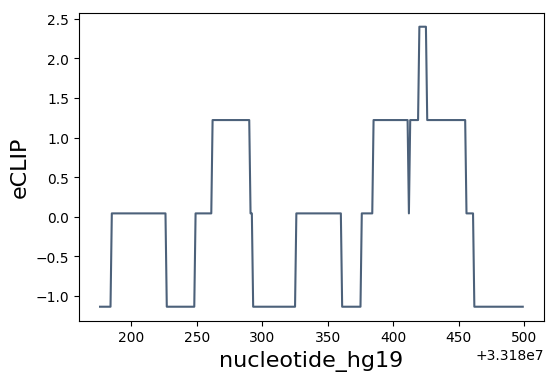

In [1098]:
super_table.plot(0, 3)

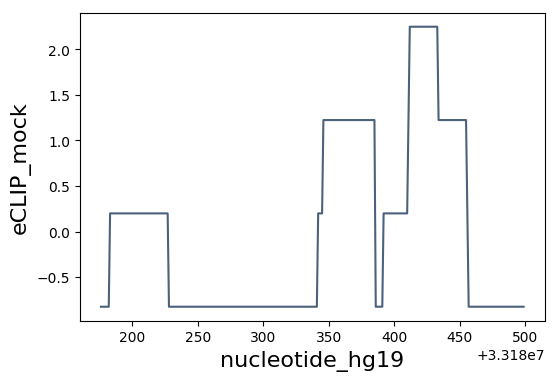

In [1099]:
super_table.plot(0, 4)

In [1083]:
chroms = []
starts = []
stops = []
strands = []
from liftover import get_lifter

utrs = Table().read_table("GCLiPP_Data/hg19_3putr.csv")
converter = get_lifter('hg19', 'hg38')

for chrom,start,stop,strand in tqdm(zip(utrs.column(0),utrs.column(1),utrs.column(2),utrs.column("strands"))):
    
    if len(converter[chrom][start]) == 1 and len(converter[chrom][stop]) == 1:
        chroms.append(converter[chrom][start][0][0])
        starts.append(converter[chrom][start][0][1])
        stops.append(converter[chrom][stop][0][1])
        strands.append(converter[chrom][stop][0][2])
    else:
        chroms.append('nan')
        starts.append('nan')
        stops.append('nan')
        strands.append('nan')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [802]:
utrs.with_columns("chr", chroms, "str", starts, "stp", stops , "stran", strands).where("chr", are.not_equal_to("nan"))#.to_csv("GCLiPP_Data/hg19&hg38_3putr.csv")


chrom,start,stop,id,Unnamed: 4,strands,chr,str,stp,stran
chr1,14361,14829,NR_024540_utr3_0_0_chr1_14362_r,nan,-,chr1,14361,14829,+
chr1,14969,15038,NR_024540_utr3_1_0_chr1_14970_r,nan,-,chr1,14969,15038,+
chr1,15795,15947,NR_024540_utr3_2_0_chr1_15796_r,nan,-,chr1,15795,15947,+
chr1,16606,16765,NR_024540_utr3_3_0_chr1_16607_r,nan,-,chr1,16606,16765,+
chr1,16857,17055,NR_024540_utr3_4_0_chr1_16858_r,nan,-,chr1,16857,17055,+
chr1,17232,17436,"NR_024540_utr3_5_0_chr1_17233_r,NR_106918_utr3_0_0_chr1_ ...",nan,-,chr1,17232,17436,+
chr1,17605,17742,NR_024540_utr3_6_0_chr1_17606_r,nan,-,chr1,17605,17742,+
chr1,17914,18061,NR_024540_utr3_7_0_chr1_17915_r,nan,-,chr1,17914,18061,+
chr1,18267,18366,NR_024540_utr3_8_0_chr1_18268_r,nan,-,chr1,18267,18366,+
chr1,24737,24891,NR_024540_utr3_9_0_chr1_24738_r,nan,-,chr1,24737,24891,+


In [779]:
utrs = utrs.with_columns("chr", chroms, "str", starts, "stp", stops , "stran", strands)

In [787]:
utrs.with_column("hg38_map", ["IDDD"+ a +":"+ str(b) +"-"+ str(c) for a,b,c in zip(utrs.column("chr"), utrs.column("str"), utrs.column("stp"))]).to_csv("GCLiPP_Data/test.csv")

In [890]:
from liftover import get_lifter
converter = get_lifter('hg19', 'hg38')
chrom = '1'
start = 103786442
converter[chrom][start][0][1]

'chr1'

In [900]:
chrom = "X"
pos = 103786442 + 1000
converter[chrom][pos]

[('chrX', 104542761, '+')]